
📋 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BodyFat   436 non-null    float64
 1   Original  436 non-null    object 
 2   Sex       436 non-null    object 
 3   Age       436 non-null    int64  
 4   Weight    436 non-null    float64
 5   Height    436 non-null    float64
 6   Neck      436 non-null    float64
 7   Chest     436 non-null    float64
 8   Abdomen   436 non-null    float64
 9   Hip       436 non-null    float64
 10  Thigh     436 non-null    float64
 11  Knee      436 non-null    float64
 12  Ankle     436 non-null    float64
 13  Biceps    436 non-null    float64
 14  Forearm   436 non-null    float64
 15  Wrist     436 non-null    float64
dtypes: float64(13), int64(1), object(2)
memory usage: 54.6+ KB

📊 Descriptive Statistics:
         count       mean        std      min       25%      50%      75%  \
BodyFat 

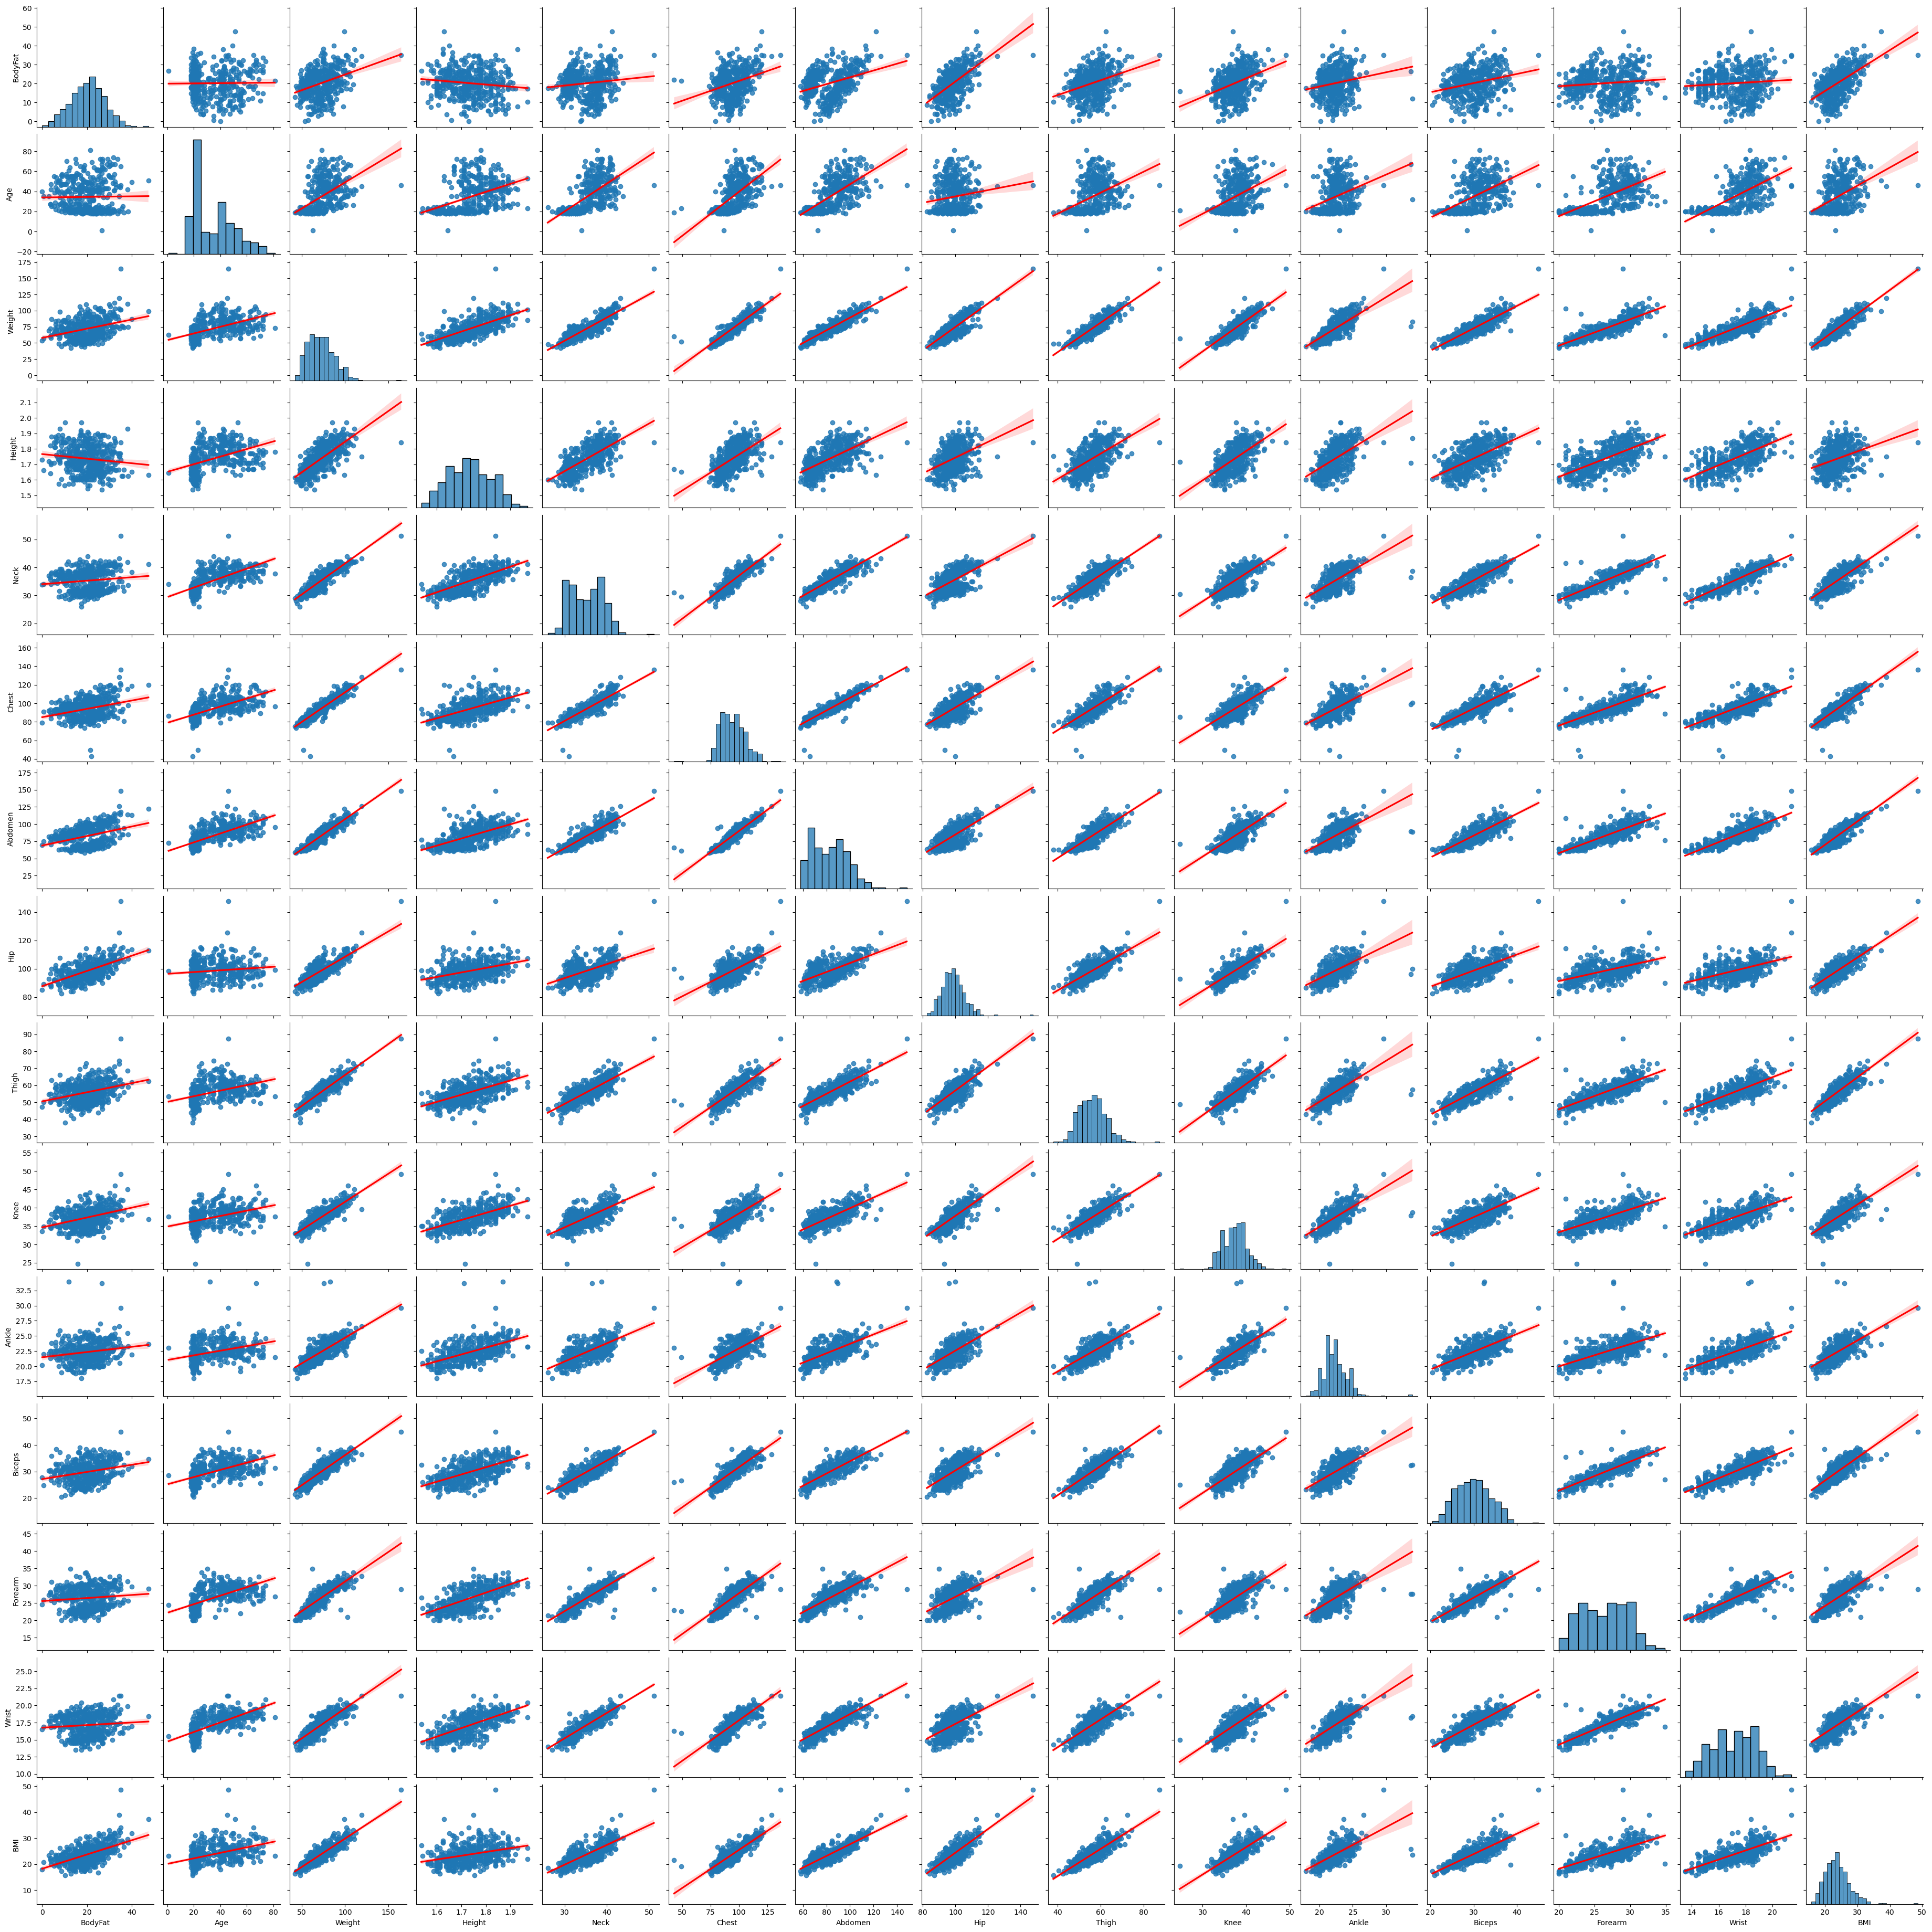

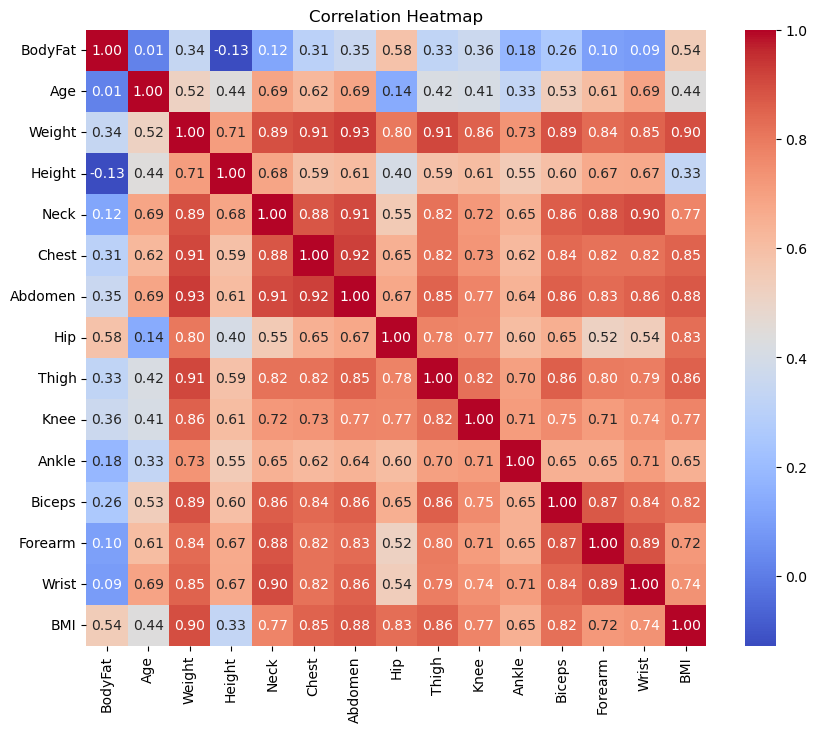

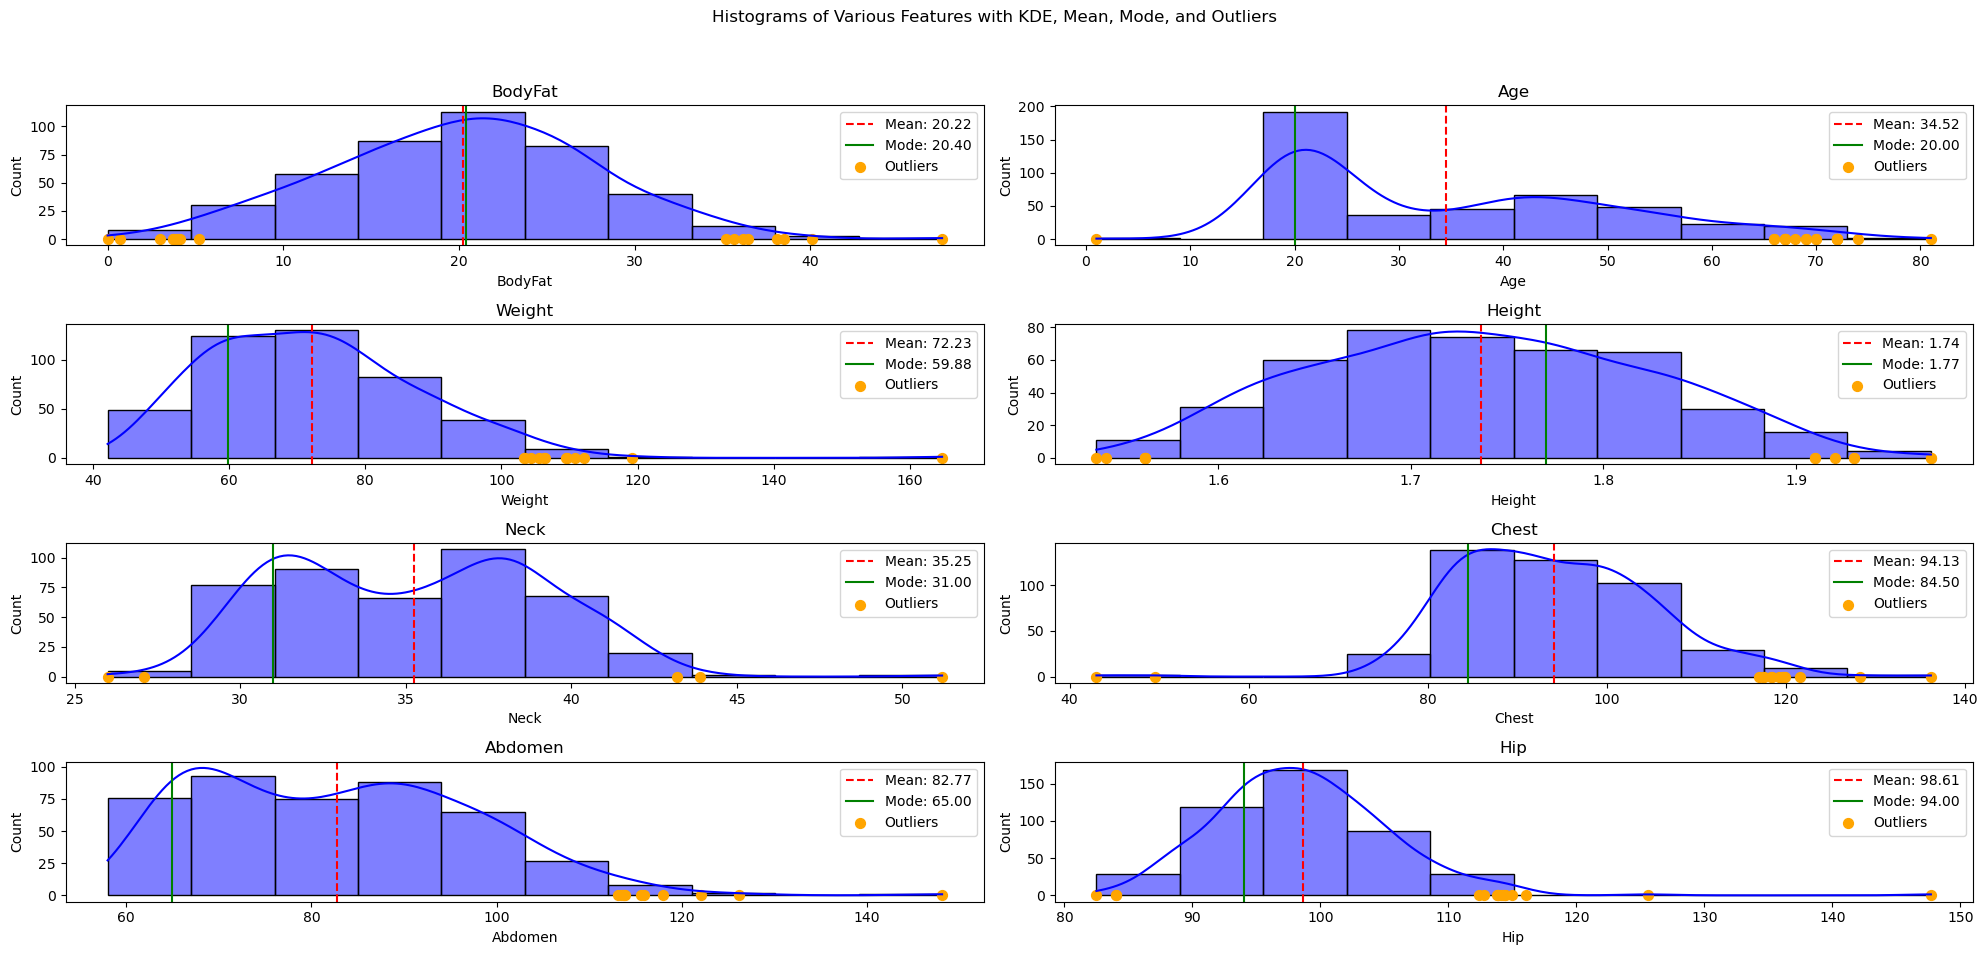


KMeans Silhouette Score: 0.3134782188299282
DBSCAN Silhouette Score: 0.19696149136798888


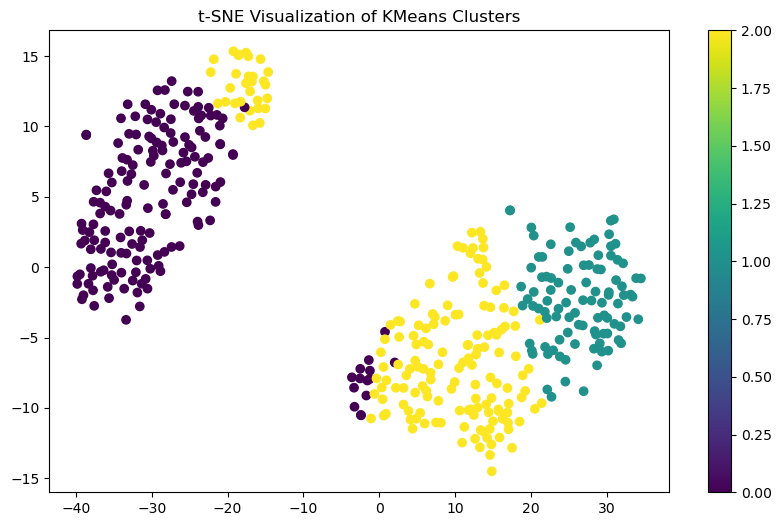

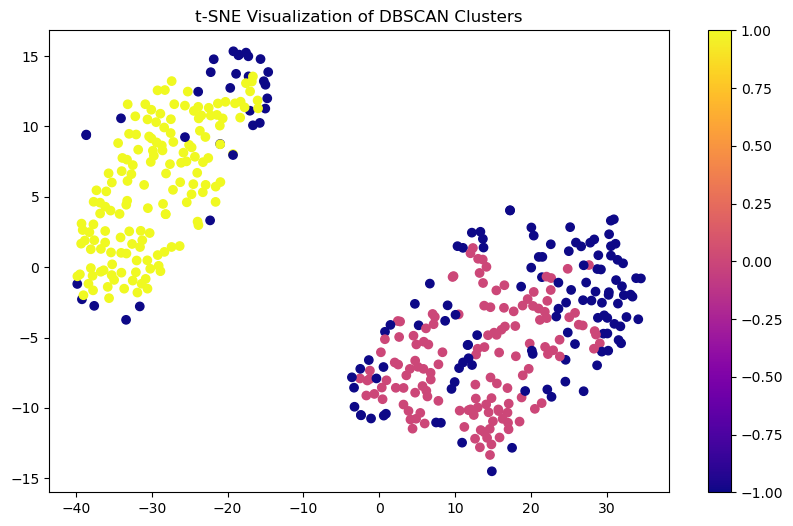

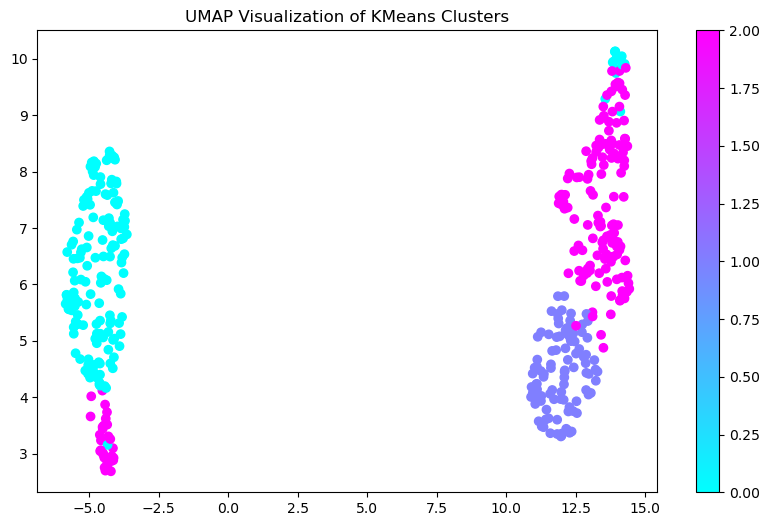

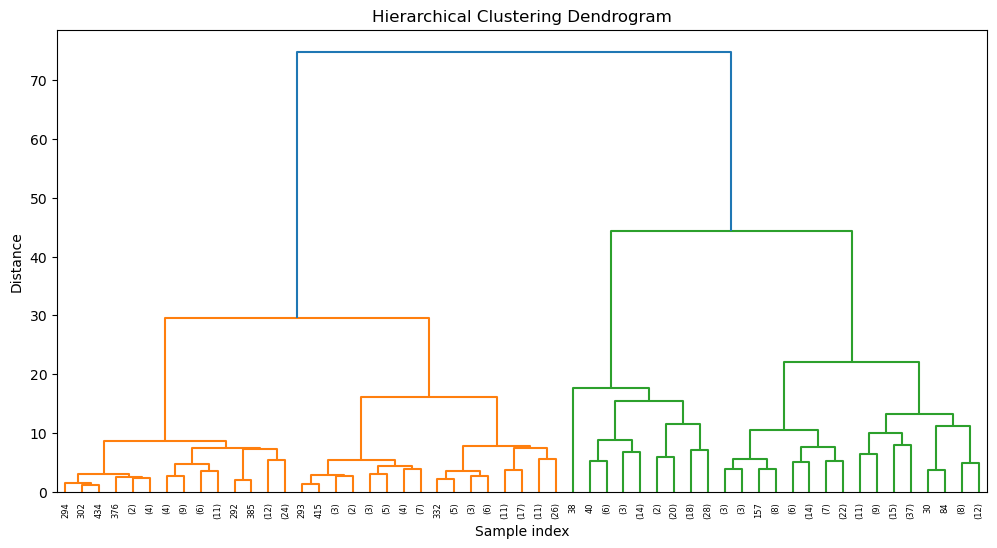

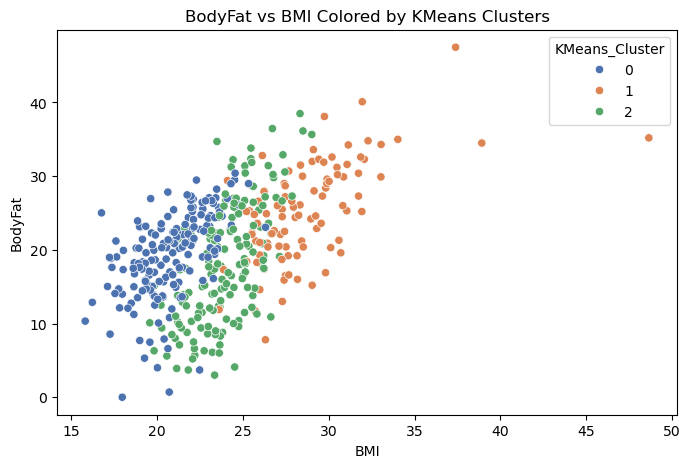

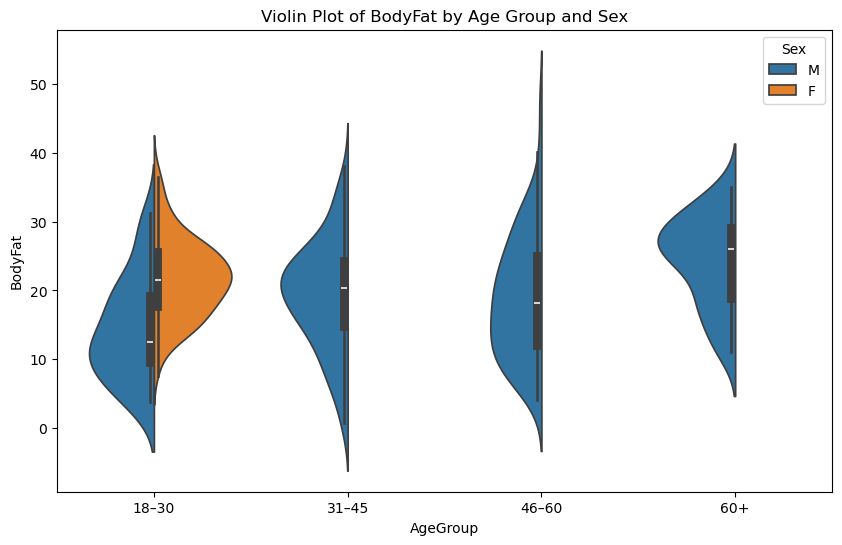

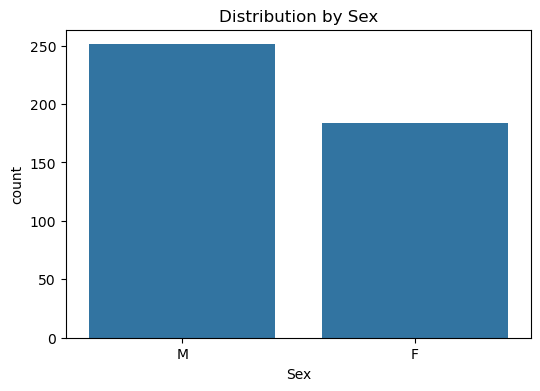

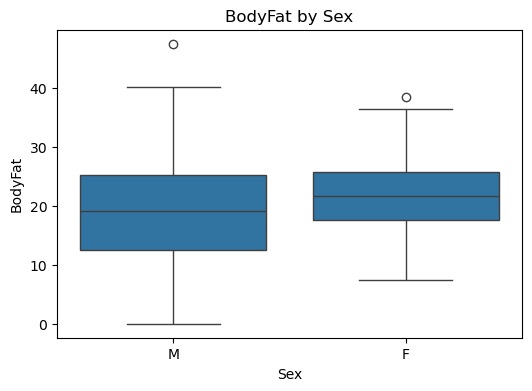

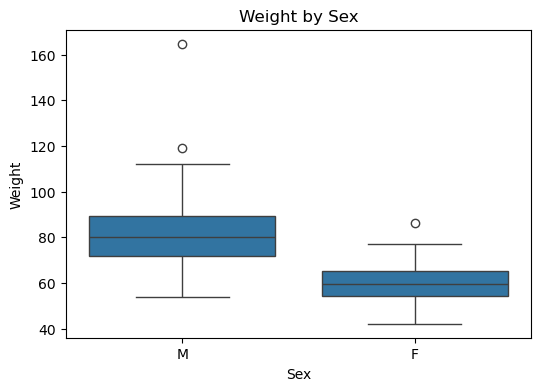

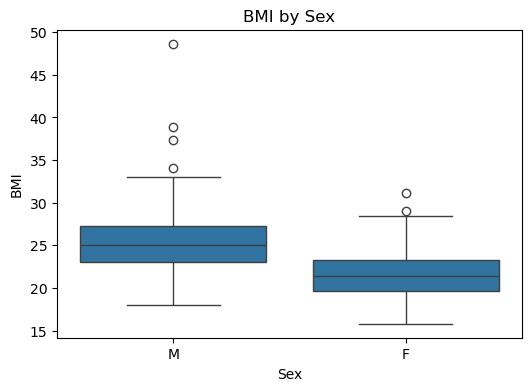

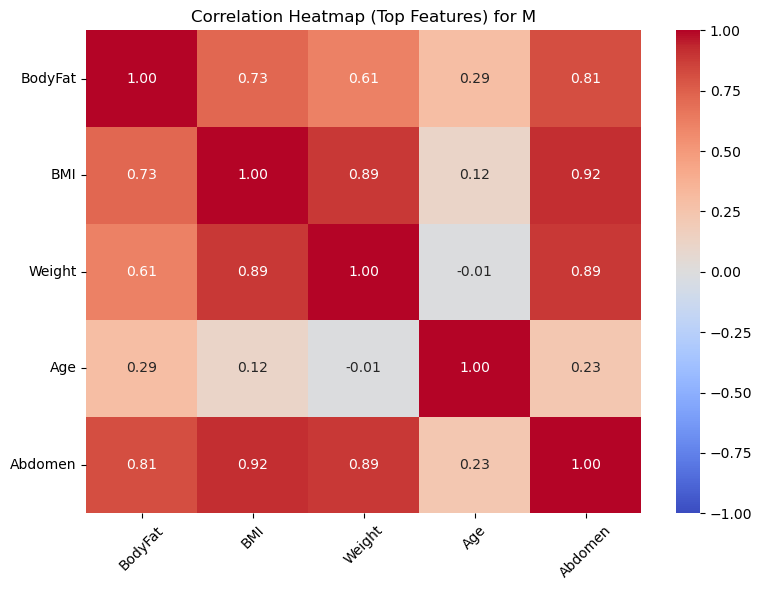

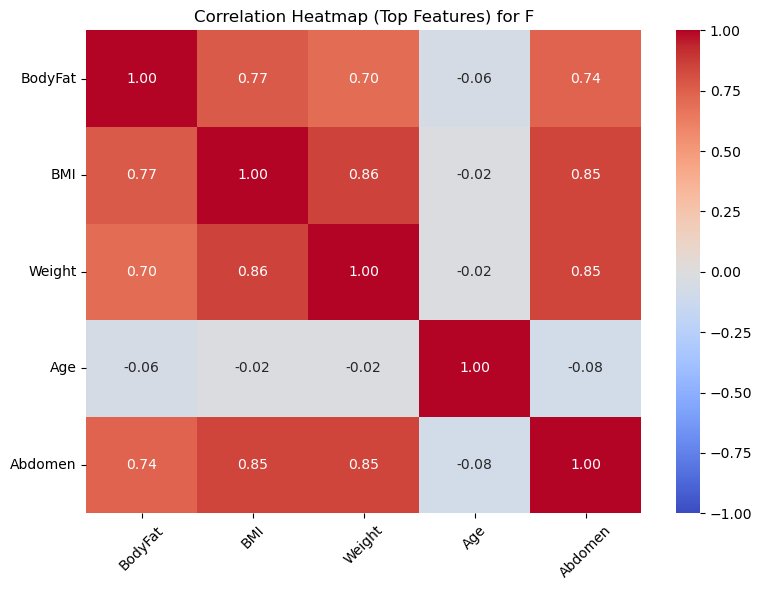

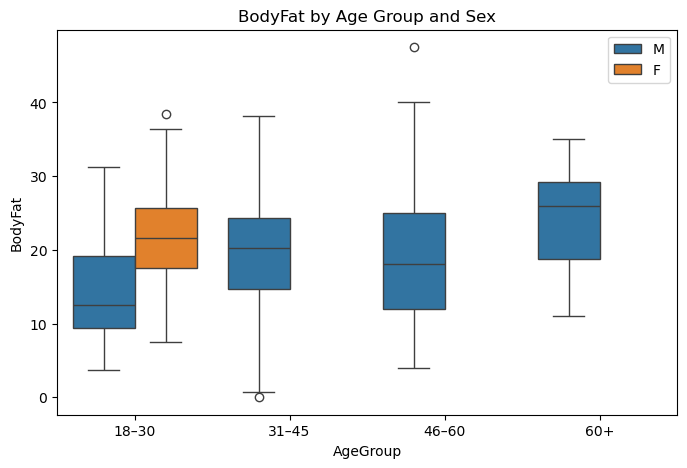

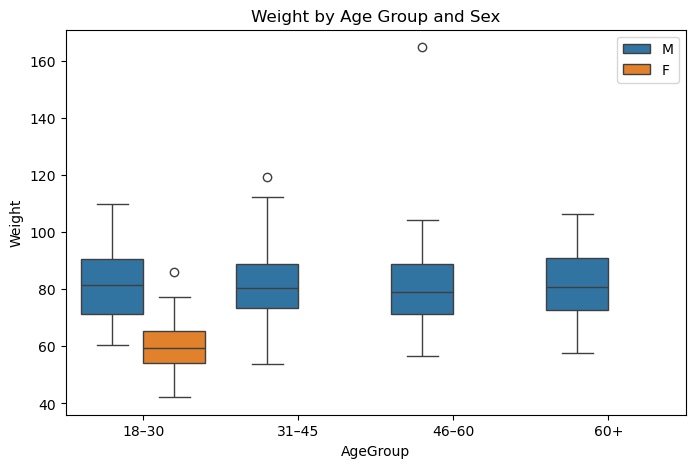

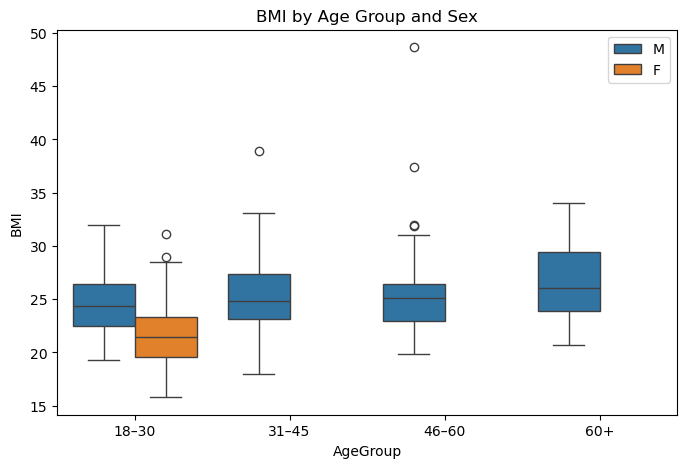

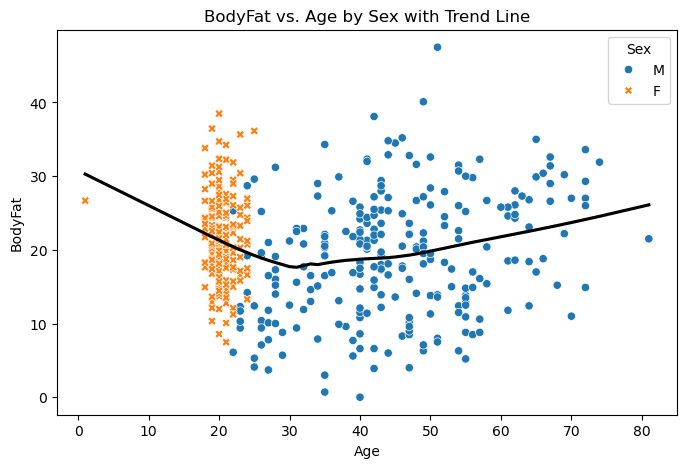

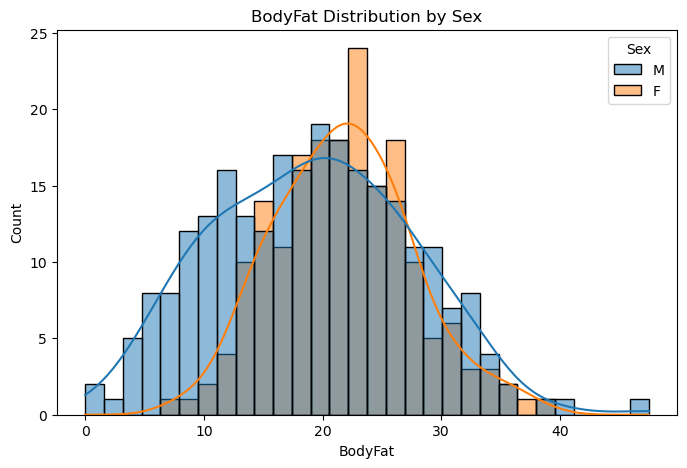


🔍 Top correlations with BodyFat for M:
BodyFat    1.000000
Abdomen    0.812593
BMI        0.725926
Chest      0.702918
Hip        0.620125
Weight     0.610845
Name: BodyFat, dtype: float64

🔍 Top correlations with BodyFat for F:
BodyFat    1.000000
BMI        0.766302
Abdomen    0.740075
Hip        0.714758
Weight     0.701040
Biceps     0.670248
Name: BodyFat, dtype: float64


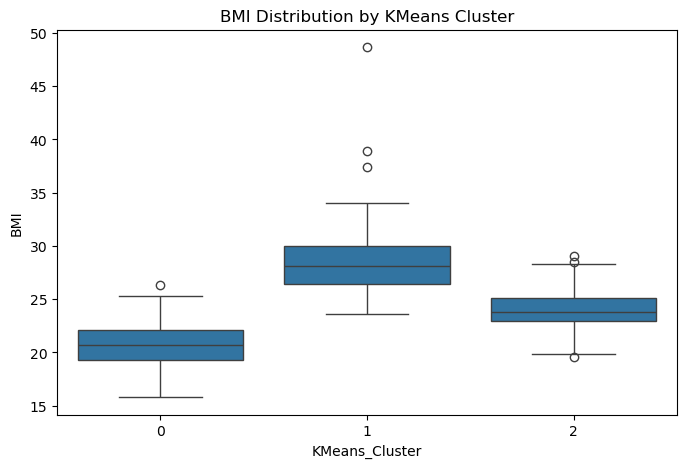

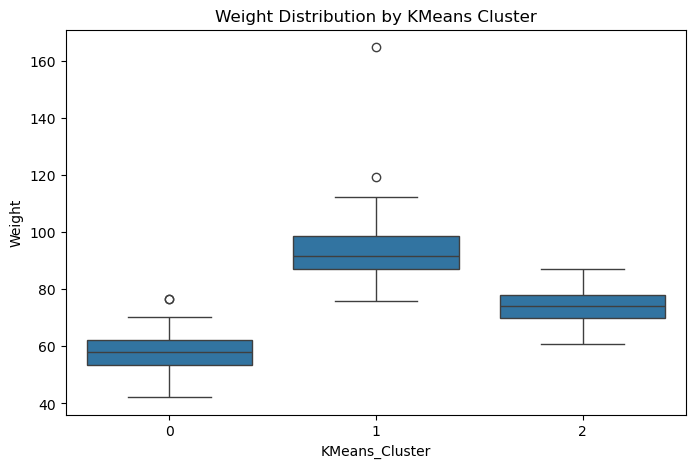

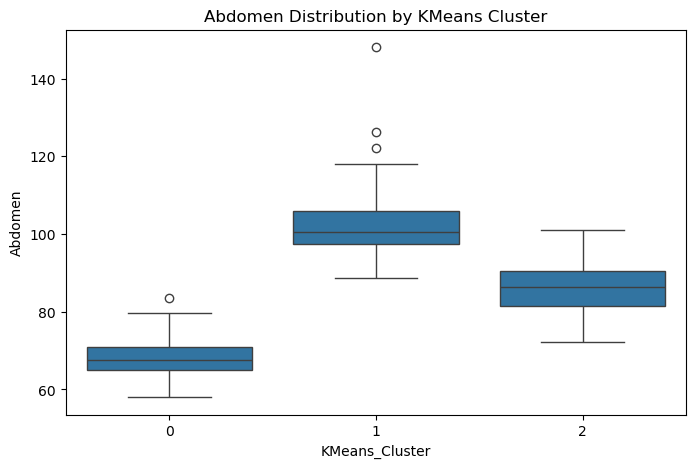

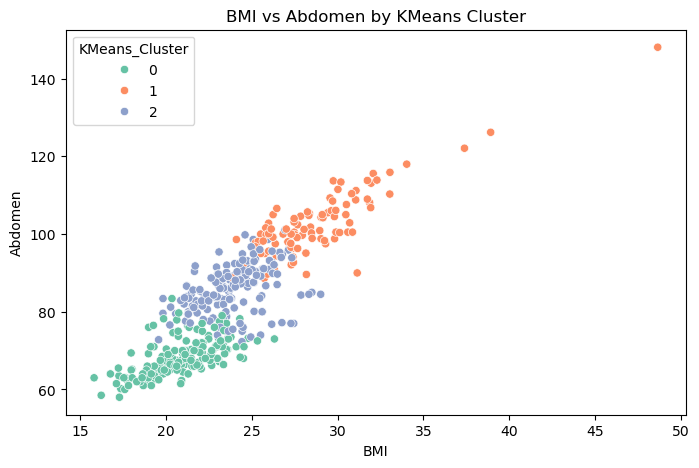

In [5]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.inspection import PartialDependenceDisplay
from umap import UMAP
from scipy.cluster.hierarchy import dendrogram, linkage
from pathlib import Path
import warnings
from math import pi
import os

os.environ["LOKY_MAX_CPU_COUNT"] = "12"  # set it to how many logical cores you want to use

# Suppress specific FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning, message=".*force_all_finite.*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*n_jobs value 1 overridden.*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*KMeans is known to have a memory leak.*")

# Load dataset
# Use relative path to the dataset
file_path = Path("data/kaggle_datasets/body_fat/bodyfat.csv")
df_pl = pl.read_csv(file_path)
df = df_pl.to_pandas()  # For compatibility with Seaborn and sklearn

# Initial info and descriptive stats
print("\n📋 Dataset Info:")
df.info()

print("\n📊 Descriptive Statistics:")
print(df.describe().T)

# Preprocessing
# Fix suspected height/weight inversions
inverted = (df['Height'] < 1.0) & (df['Weight'] > 100)
df.loc[inverted, ['Height', 'Weight']] = df.loc[inverted, ['Weight', 'Height']].values

# Check BMI plausibility and fix extreme values
mask_valid_height = df['Height'] > 0.5  # meters
mask_valid_weight = df['Weight'] > 10   # kg

# Print full rows of invalid height/weight
bmi_check = df[~(mask_valid_height & mask_valid_weight)]
if not bmi_check.empty:
    print("\n⚠️ Invalid height or weight detected:")
    print(bmi_check.to_string(index=False))

# Filter only valid height and weight
df = df[mask_valid_height & mask_valid_weight].copy()
df['BMI'] = df['Weight'] / (df['Height'] ** 2)

# Flag and drop extreme BMI outliers
df['BMI_outlier'] = (df['BMI'] > 100).astype(int)
bmi_outliers = df[df['BMI_outlier'] == 1]
if not bmi_outliers.empty:
    print("\n⚠️ BMI Outliers Check:")
    print(bmi_outliers.to_string(index=False))
    df = df[df['BMI_outlier'] == 0]
    print("\n🗑 Dropped BMI outliers.")

# Drop helper column
df.drop(columns='BMI_outlier', inplace=True)

# Drop missing values
df.dropna(inplace=True)
df_numeric = df.select_dtypes(include=np.number)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# Visualizations: Pairplot
sns.pairplot(df_numeric, kind='reg', plot_kws={'line_kws':{'color':'red'}})
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Histograms with KDE, Mean, Mode, Outliers
fig, axes = plt.subplots(4, 2, figsize=(20, 10))
axes = axes.flatten()

for ax, col in zip(axes, df_numeric.columns):
    sns.histplot(df[col], bins=10, kde=True, color='blue', edgecolor='black', ax=ax)
    mean = df[col].mean()
    mode = df[col].mode()[0]
    std_dev = df[col].std()
    outliers = df[col][np.abs(df[col] - mean) > 2 * std_dev]
    ax.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
    ax.axvline(mode, color='green', linestyle='-', label=f'Mode: {mode:.2f}')
    ax.scatter(outliers, np.zeros_like(outliers) - 0.01, color='orange', s=50, label='Outliers')
    ax.legend()
    ax.set_title(col)

plt.suptitle("Histograms of Various Features with KDE, Mean, Mode, and Outliers")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(df_scaled)
df['KMeans_Cluster'] = kmeans_labels

# DBSCAN Clustering
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(df_scaled)
df['DBSCAN_Cluster'] = dbscan_labels

# Cluster Evaluation: Silhouette Score
print("\nKMeans Silhouette Score:", silhouette_score(df_scaled, kmeans_labels))
print("DBSCAN Silhouette Score:", silhouette_score(df_scaled, dbscan_labels))

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(df_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=kmeans_labels, cmap='viridis')
plt.title("t-SNE Visualization of KMeans Clusters")
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=dbscan_labels, cmap='plasma')
plt.title("t-SNE Visualization of DBSCAN Clusters")
plt.colorbar()
plt.show()

# UMAP Visualization
umap = UMAP(n_components=2, random_state=42)
umap_results = umap.fit_transform(df_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(umap_results[:, 0], umap_results[:, 1], c=kmeans_labels, cmap='cool')
plt.title("UMAP Visualization of KMeans Clusters")
plt.colorbar()
plt.show()

# Hierarchical Clustering
linkage_matrix = linkage(df_scaled, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()

# Overlay Clusters
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='BMI', y='BodyFat', hue='KMeans_Cluster', palette='deep')
plt.title("BodyFat vs BMI Colored by KMeans Clusters")
plt.show()

# Violin plots for AgeGroup and Sex
bins = [17, 30, 45, 60, 100]
labels = ['18–30', '31–45', '46–60', '60+']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels)

plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='AgeGroup', y='BodyFat', hue='Sex', split=True)
plt.title("Violin Plot of BodyFat by Age Group and Sex")
plt.show()

# Feature Engineering
categorical_cols = ['Sex', 'AgeGroup']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Flag Outliers
for col in df_numeric.columns:
    mean = df[col].mean()
    std = df[col].std()
    df[f'{col}_outlier'] = (np.abs(df[col] - mean) > 2 * std).astype(int)

# Sex Analysis
plt.figure(figsize=(6, 4))
sns.countplot(x='Sex', data=df)
plt.title("Distribution by Sex")
plt.show()

# Sex-based boxplots
key_features = ['BodyFat', 'Weight', 'BMI']
for feature in key_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Sex', y=feature, data=df)
    plt.title(f"{feature} by Sex")
    plt.show()

# Sex-based correlation heatmaps (cleaned and focused)
selected_features = ['BodyFat', 'BMI', 'Weight', 'Age', 'Abdomen']
for sex in df['Sex'].unique():
    sex_df = df[df['Sex'] == sex][selected_features].dropna()
    corr_matrix = sex_df.corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title(f"Correlation Heatmap (Top Features) for {sex}")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Age Group Boxplots
for feature in key_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='AgeGroup', y=feature, hue='Sex', data=df)
    plt.title(f"{feature} by Age Group and Sex")
    plt.legend()
    plt.show()

# Interaction plot: Age vs. BodyFat with hue=Sex
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Age', y='BodyFat', hue='Sex', style='Sex')
sns.regplot(data=df, x='Age', y='BodyFat', scatter=False, color='black', lowess=True)
plt.title("BodyFat vs. Age by Sex with Trend Line")
plt.show()

# Interactive Dashboard (Optional Example with Plotly)
fig = px.scatter(df, x='BMI', y='BodyFat', color='KMeans_Cluster', hover_data=['Age', 'Sex'])
fig.update_layout(title="Interactive Clustered Scatterplot: BMI vs BodyFat")
fig.show()

# BodyFat Distribution by Sex
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='BodyFat', hue='Sex', kde=True, bins=30)
plt.title("BodyFat Distribution by Sex")
plt.show()

# Correlation with BodyFat by Sex
for sex in df['Sex'].unique():
    corr = df[df['Sex'] == sex].corr(numeric_only=True)['BodyFat'].sort_values(ascending=False)
    print(f"\n🔍 Top correlations with BodyFat for {sex}:")
    print(corr.head(6))

# Feature distribution by cluster
for feature in ['BMI', 'Weight', 'Abdomen']:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x='KMeans_Cluster', y=feature)
    plt.title(f"{feature} Distribution by KMeans Cluster")
    plt.show()

# BMI vs Abdomen by Cluster
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='BMI', y='Abdomen', hue='KMeans_Cluster', palette='Set2')
plt.title("BMI vs Abdomen by KMeans Cluster")
plt.show()

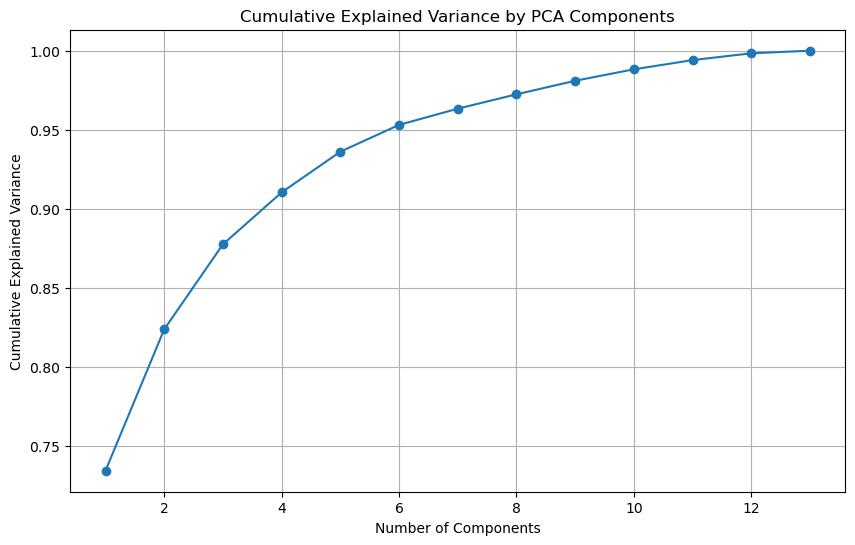

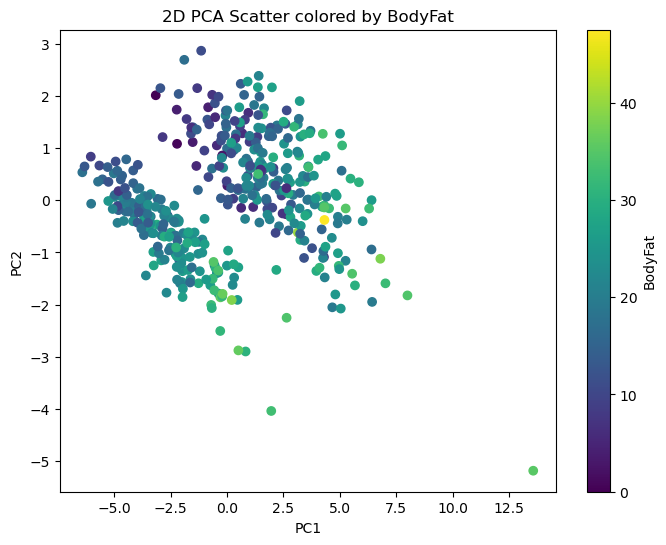


🎯 Top 5 Features Based on F-Score:
Weight: 58.95
Abdomen: 63.58
Hip: 229.92
Thigh: 53.41
Knee: 67.63



✅ Saved selected features to 'selected_features_for_modeling.csv'


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from pathlib import Path
import warnings

# Suppress warnings for clean output
warnings.filterwarnings("ignore")

# Load cleaned dataset (assuming prior cleaning done)
file_path = Path("C:/Users/AC/Projects/LeanAI/Project/notebooks/EDA/data/kaggle_datasets/body_fat/bodyfat.csv")
df = pd.read_csv(file_path)

# Basic numeric check
df = df.select_dtypes(include=np.number).dropna()

# Feature and target separation
X = df.drop(columns=['BodyFat'])
y = df['BodyFat']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ----- PCA Analysis -----
pca = PCA()
pca_result = pca.fit_transform(X_scaled)

explained_var = pca.explained_variance_ratio_.cumsum()
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(explained_var)+1), explained_var, marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# 2D PCA Scatter
pca_2d = PCA(n_components=2)
pca_2d_result = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(pca_2d_result[:, 0], pca_2d_result[:, 1], c=y, cmap='viridis')
plt.title("2D PCA Scatter colored by BodyFat")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='BodyFat')
plt.show()

# ----- Feature Selection -----
selector = SelectKBest(score_func=f_regression, k=5)
X_selected = selector.fit_transform(X_scaled, y)
selected_features = X.columns[selector.get_support()]

print("\n🎯 Top 5 Features Based on F-Score:")
for feat, score in zip(selected_features, selector.scores_[selector.get_support()]):
    print(f"{feat}: {score:.2f}")

# Interactive Visualization with Selected Features
if len(selected_features) >= 2:
    fig = px.scatter(df, x=selected_features[0], y=selected_features[1], color=y,
                     labels={selected_features[0]: selected_features[0],
                             selected_features[1]: selected_features[1]},
                     title=f"Interactive Scatter: {selected_features[0]} vs {selected_features[1]} colored by BodyFat")
    fig.show()

# Export selected features for use in modeling phase
selected_df = df[selected_features.tolist() + ['BodyFat']]
selected_df.to_csv("selected_features_for_modeling.csv", index=False)
print("\n✅ Saved selected features to 'selected_features_for_modeling.csv'")


In [ ]:
!kaggle datasets list -s [body-fat]

ref                                                         title                                              size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  -------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
fedesoriano/body-fat-prediction-dataset                     Body Fat Prediction Dataset                        7607  2021-06-14 12:23:45.827000          24341        185  1.0              
simonezappatini/body-fat-extended-dataset                   Body Fat Extended Dataset                         11823  2023-11-15 14:28:24.333000           1816         34  1.0              
vishweshsalodkar/body-fat-percentage                        Body Fat Percentage of Women                       6686  2021-10-10 19:56:44.650000            784         24  0.8235294        
fedesoriano/stroke-prediction-dataset                  

In [ ]:
!kaggle competitions list

ref                                                                               deadline             category                reward  teamCount  userHasEntered  
--------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/ai-mathematical-olympiad-progress-prize-2     2025-04-01 23:59:00  Featured         2,117,152 Usd       2179           False  
https://www.kaggle.com/competitions/stanford-rna-3d-folding                       2025-05-29 23:59:00  Featured            75,000 Usd        617           False  
https://www.kaggle.com/competitions/byu-locating-bacterial-flagellar-motors-2025  2025-06-04 23:59:00  Research            65,000 Usd        355           False  
https://www.kaggle.com/competitions/march-machine-learning-mania-2025             2025-03-20 16:00:00  Featured            50,000 Usd       1179           False  
https://www.kaggle.com

shape: (5, 15)
┌─────────┬─────────┬─────┬────────┬───┬───────┬────────┬─────────┬───────┐
│ Density ┆ BodyFat ┆ Age ┆ Weight ┆ … ┆ Ankle ┆ Biceps ┆ Forearm ┆ Wrist │
│ ---     ┆ ---     ┆ --- ┆ ---    ┆   ┆ ---   ┆ ---    ┆ ---     ┆ ---   │
│ f64     ┆ f64     ┆ i64 ┆ f64    ┆   ┆ f64   ┆ f64    ┆ f64     ┆ f64   │
╞═════════╪═════════╪═════╪════════╪═══╪═══════╪════════╪═════════╪═══════╡
│ 1.0708  ┆ 12.3    ┆ 23  ┆ 154.25 ┆ … ┆ 21.9  ┆ 32.0   ┆ 27.4    ┆ 17.1  │
│ 1.0853  ┆ 6.1     ┆ 22  ┆ 173.25 ┆ … ┆ 23.4  ┆ 30.5   ┆ 28.9    ┆ 18.2  │
│ 1.0414  ┆ 25.3    ┆ 22  ┆ 154.0  ┆ … ┆ 24.0  ┆ 28.8   ┆ 25.2    ┆ 16.6  │
│ 1.0751  ┆ 10.4    ┆ 26  ┆ 184.75 ┆ … ┆ 22.8  ┆ 32.4   ┆ 29.4    ┆ 18.2  │
│ 1.034   ┆ 28.7    ┆ 24  ┆ 184.25 ┆ … ┆ 24.0  ┆ 32.2   ┆ 27.7    ┆ 17.7  │
└─────────┴─────────┴─────┴────────┴───┴───────┴────────┴─────────┴───────┘

shape: (5, 15)
┌─────────┬─────────┬─────┬────────┬───┬───────┬────────┬─────────┬───────┐
│ Density ┆ BodyFat ┆ Age ┆ Weight ┆ … ┆ Ankle ┆ Biceps ┆ Forearm ┆ Wrist │
│ ---     ┆ ---     ┆ --- ┆ ---    ┆   ┆ ---   ┆ ---    ┆ ---     ┆ ---   │
│ f64     ┆ f64     ┆ i64 ┆ f64    ┆   ┆ f64   ┆ f64    ┆ f64     ┆ f64   │
╞═════════╪═════════╪═════╪════════╪═══╪═══════╪════════╪═════════╪═══════╡
│ 1.0736  ┆ 11.0    ┆ 70  ┆ 134.25 ┆ … ┆ 21.5  ┆ 25.6   ┆ 25.7    ┆ 18.5  │
│ 1.0236  ┆ 33.6    ┆ 72  ┆ 201.0  ┆ … ┆ 23.2  ┆ 35.2   ┆ 28.6    ┆ 20.1  │
│ 1.0328  ┆ 29.3    ┆ 72  ┆ 186.75 ┆ … ┆ 21.5  ┆ 31.3   ┆ 27.2    ┆ 18.0  │
│ 1.0399  ┆ 26.0    ┆ 72  ┆ 190.75 ┆ … ┆ 22.7  ┆ 30.5   ┆ 29.4    ┆ 19.8  │
│ 1.0271  ┆ 31.9    ┆ 74  ┆ 207.5  ┆ … ┆ 24.6  ┆ 33.7   ┆ 30.0    ┆ 20.9  │
└─────────┴─────────┴─────┴────────┴───┴───────┴────────┴─────────┴───────┘

shape: (5, 15)
┌─────────┬─────────┬─────┬────────┬───┬───────┬────────┬─────────┬───────┐
│ Density ┆ BodyFat ┆ Age ┆ Weight ┆ … ┆ Ankle ┆ Biceps ┆ Forearm ┆ Wrist │
│ ---     ┆ ---     ┆ --- ┆ ---    ┆   ┆ ---   ┆ ---    ┆ ---     ┆ ---   │
│ f64     ┆ f64     ┆ i64 ┆ f64    ┆   ┆ f64   ┆ f64    ┆ f64     ┆ f64   │
╞═════════╪═════════╪═════╪════════╪═══╪═══════╪════════╪═════════╪═══════╡
│ 1.0433  ┆ 24.5    ┆ 52  ┆ 199.25 ┆ … ┆ 22.9  ┆ 35.7   ┆ 30.4    ┆ 19.2  │
│ 1.0911  ┆ 3.7     ┆ 27  ┆ 159.25 ┆ … ┆ 22.5  ┆ 29.9   ┆ 28.2    ┆ 17.7  │
│ 1.0775  ┆ 9.4     ┆ 31  ┆ 151.25 ┆ … ┆ 21.0  ┆ 27.0   ┆ 26.3    ┆ 16.5  │
│ 1.067   ┆ 13.9    ┆ 43  ┆ 164.25 ┆ … ┆ 23.4  ┆ 29.7   ┆ 27.4    ┆ 18.3  │
│ 1.0403  ┆ 25.8    ┆ 61  ┆ 178.0  ┆ … ┆ 22.7  ┆ 33.6   ┆ 29.0    ┆ 18.8  │
└─────────┴─────────┴─────┴────────┴───┴───────┴────────┴─────────┴───────┘

Schema([('Density', Float64),
        ('BodyFat', Float64),
        ('Age', Int64),
        ('Weight', Float64),
        ('Height', Float64),
        ('Neck', Float64),
        ('Chest', Float64),
        ('Abdomen', Float64),
        ('Hip', Float64),
        ('Thigh', Float64),
        ('Knee', Float64),
        ('Ankle', Float64),
        ('Biceps', Float64),
        ('Forearm', Float64),
        ('Wrist', Float64)])

[Float64,
 Float64,
 Int64,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64]

(252, 15)

['Density',
 'BodyFat',
 'Age',
 'Weight',
 'Height',
 'Neck',
 'Chest',
 'Abdomen',
 'Hip',
 'Thigh',
 'Knee',
 'Ankle',
 'Biceps',
 'Forearm',
 'Wrist']

252

shape: (1, 15)
┌─────────┬─────────┬─────┬────────┬───┬───────┬────────┬─────────┬───────┐
│ Density ┆ BodyFat ┆ Age ┆ Weight ┆ … ┆ Ankle ┆ Biceps ┆ Forearm ┆ Wrist │
│ ---     ┆ ---     ┆ --- ┆ ---    ┆   ┆ ---   ┆ ---    ┆ ---     ┆ ---   │
│ u32     ┆ u32     ┆ u32 ┆ u32    ┆   ┆ u32   ┆ u32    ┆ u32     ┆ u32   │
╞═════════╪═════════╪═════╪════════╪═══╪═══════╪════════╪═════════╪═══════╡
│ 252     ┆ 252     ┆ 252 ┆ 252    ┆ … ┆ 252   ┆ 252    ┆ 252     ┆ 252   │
└─────────┴─────────┴─────┴────────┴───┴───────┴────────┴─────────┴───────┘

shape: (252,)
Series: '' [bool]
[
	false
	false
	false
	false
	false
	…
	false
	false
	false
	false
	false
]

shape: (252,)
Series: '' [bool]
[
	true
	true
	true
	true
	true
	…
	true
	true
	true
	true
	true
]

shape: (1, 15)
┌─────────┬─────────┬─────┬────────┬───┬───────┬────────┬─────────┬───────┐
│ Density ┆ BodyFat ┆ Age ┆ Weight ┆ … ┆ Ankle ┆ Biceps ┆ Forearm ┆ Wrist │
│ ---     ┆ ---     ┆ --- ┆ ---    ┆   ┆ ---   ┆ ---    ┆ ---     ┆ ---   │
│ f64     ┆ f64     ┆ i64 ┆ f64    ┆   ┆ f64   ┆ f64    ┆ f64     ┆ f64   │
╞═════════╪═════════╪═════╪════════╪═══╪═══════╪════════╪═════════╪═══════╡
│ 0.995   ┆ 0.0     ┆ 22  ┆ 118.5  ┆ … ┆ 19.1  ┆ 24.8   ┆ 21.0    ┆ 15.8  │
└─────────┴─────────┴─────┴────────┴───┴───────┴────────┴─────────┴───────┘

shape: (1, 15)
┌─────────┬─────────┬─────┬────────┬───┬───────┬────────┬─────────┬───────┐
│ Density ┆ BodyFat ┆ Age ┆ Weight ┆ … ┆ Ankle ┆ Biceps ┆ Forearm ┆ Wrist │
│ ---     ┆ ---     ┆ --- ┆ ---    ┆   ┆ ---   ┆ ---    ┆ ---     ┆ ---   │
│ f64     ┆ f64     ┆ i64 ┆ f64    ┆   ┆ f64   ┆ f64    ┆ f64     ┆ f64   │
╞═════════╪═════════╪═════╪════════╪═══╪═══════╪════════╪═════════╪═══════╡
│ 1.1089  ┆ 47.5    ┆ 81  ┆ 363.15 ┆ … ┆ 33.9  ┆ 45.0   ┆ 34.9    ┆ 21.4  │
└─────────┴─────────┴─────┴────────┴───┴───────┴────────┴─────────┴───────┘

shape: (1, 15)
┌──────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ Density  ┆ BodyFat   ┆ Age       ┆ Weight    ┆ … ┆ Ankle     ┆ Biceps    ┆ Forearm   ┆ Wrist     │
│ ---      ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ f64      ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1.055574 ┆ 19.150794 ┆ 44.884921 ┆ 178.92440 ┆ … ┆ 23.102381 ┆ 32.273413 ┆ 28.663889 ┆ 18.229762 │
│          ┆           ┆           ┆ 5         ┆   ┆           ┆           ┆           ┆           │
└──────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

shape: (1, 15)
┌─────────┬─────────┬──────┬────────┬───┬───────┬────────┬─────────┬───────┐
│ Density ┆ BodyFat ┆ Age  ┆ Weight ┆ … ┆ Ankle ┆ Biceps ┆ Forearm ┆ Wrist │
│ ---     ┆ ---     ┆ ---  ┆ ---    ┆   ┆ ---   ┆ ---    ┆ ---     ┆ ---   │
│ f64     ┆ f64     ┆ f64  ┆ f64    ┆   ┆ f64   ┆ f64    ┆ f64     ┆ f64   │
╞═════════╪═════════╪══════╪════════╪═══╪═══════╪════════╪═════════╪═══════╡
│ 1.0549  ┆ 19.2    ┆ 43.0 ┆ 176.5  ┆ … ┆ 22.8  ┆ 32.05  ┆ 28.7    ┆ 18.3  │
└─────────┴─────────┴──────┴────────┴───┴───────┴────────┴─────────┴───────┘

shape: (1, 15)
┌──────────┬─────────┬──────────┬──────────┬───┬──────────┬──────────┬──────────┬──────────┐
│ Density  ┆ BodyFat ┆ Age      ┆ Weight   ┆ … ┆ Ankle    ┆ Biceps   ┆ Forearm  ┆ Wrist    │
│ ---      ┆ ---     ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ f64      ┆ f64     ┆ f64      ┆ f64      ┆   ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞══════════╪═════════╪══════════╪══════════╪═══╪══════════╪══════════╪══════════╪══════════╡
│ 0.019031 ┆ 8.36874 ┆ 12.60204 ┆ 29.38916 ┆ … ┆ 1.694893 ┆ 3.021274 ┆ 2.020691 ┆ 0.933585 │
└──────────┴─────────┴──────────┴──────────┴───┴──────────┴──────────┴──────────┴──────────┘

shape: (1, 15)
┌──────────┬───────────┬────────────┬────────────┬───┬──────────┬──────────┬──────────┬──────────┐
│ Density  ┆ BodyFat   ┆ Age        ┆ Weight     ┆ … ┆ Ankle    ┆ Biceps   ┆ Forearm  ┆ Wrist    │
│ ---      ┆ ---       ┆ ---        ┆ ---        ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ f64      ┆ f64       ┆ f64        ┆ f64        ┆   ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞══════════╪═══════════╪════════════╪════════════╪═══╪══════════╪══════════╪══════════╪══════════╡
│ 0.000362 ┆ 70.035816 ┆ 158.811405 ┆ 863.722719 ┆ … ┆ 2.872664 ┆ 9.128095 ┆ 4.083193 ┆ 0.871581 │
└──────────┴───────────┴────────────┴────────────┴───┴──────────┴──────────┴──────────┴──────────┘

shape: (1, 15)
┌──────────┬─────────┬───────┬──────────┬───┬────────┬────────┬─────────┬────────┐
│ Density  ┆ BodyFat ┆ Age   ┆ Weight   ┆ … ┆ Ankle  ┆ Biceps ┆ Forearm ┆ Wrist  │
│ ---      ┆ ---     ┆ ---   ┆ ---      ┆   ┆ ---    ┆ ---    ┆ ---     ┆ ---    │
│ f64      ┆ f64     ┆ i64   ┆ f64      ┆   ┆ f64    ┆ f64    ┆ f64     ┆ f64    │
╞══════════╪═════════╪═══════╪══════════╪═══╪════════╪════════╪═════════╪════════╡
│ 266.0046 ┆ 4826.0  ┆ 11311 ┆ 45088.95 ┆ … ┆ 5821.8 ┆ 8132.9 ┆ 7223.3  ┆ 4593.9 │
└──────────┴─────────┴───────┴──────────┴───┴────────┴────────┴─────────┴────────┘

shape: (252, 15)
┌─────────┬─────────┬─────┬────────┬───┬───────┬────────┬─────────┬───────┐
│ Density ┆ BodyFat ┆ Age ┆ Weight ┆ … ┆ Ankle ┆ Biceps ┆ Forearm ┆ Wrist │
│ ---     ┆ ---     ┆ --- ┆ ---    ┆   ┆ ---   ┆ ---    ┆ ---     ┆ ---   │
│ f64     ┆ f64     ┆ i64 ┆ f64    ┆   ┆ f64   ┆ f64    ┆ f64     ┆ f64   │
╞═════════╪═════════╪═════╪════════╪═══╪═══════╪════════╪═════════╪═══════╡
│ 1.0758  ┆ 10.1    ┆ 27  ┆ 146.0  ┆ … ┆ 23.8  ┆ 27.8   ┆ 26.3    ┆ 17.4  │
│ 1.0853  ┆ 6.1     ┆ 22  ┆ 173.25 ┆ … ┆ 23.4  ┆ 30.5   ┆ 28.9    ┆ 18.2  │
│ 1.0207  ┆ 35.0    ┆ 65  ┆ 224.5  ┆ … ┆ 23.4  ┆ 34.9   ┆ 30.1    ┆ 19.4  │
│ 1.0453  ┆ 23.6    ┆ 41  ┆ 232.75 ┆ … ┆ 24.7  ┆ 37.2   ┆ 31.8    ┆ 20.0  │
│ 1.0472  ┆ 22.7    ┆ 40  ┆ 171.25 ┆ … ┆ 23.0  ┆ 31.2   ┆ 28.4    ┆ 17.1  │
│ …       ┆ …       ┆ …   ┆ …      ┆ … ┆ …     ┆ …      ┆ …       ┆ …     │
│ 1.0583  ┆ 17.7    ┆ 42  ┆ 168.0  ┆ … ┆ 22.3  ┆ 30.8   ┆ 27.8    ┆ 16.9  │
│ 1.0725  ┆ 11.5    ┆ 40  ┆ 145.75 ┆ … ┆ 21.8  ┆ 31.4   ┆ 28.3    ┆ 17.2  │
│ 1.0481  ┆ 22.4    ┆ 40  ┆ 168.25 ┆ … ┆ 22.5  ┆ 31.7   ┆ 27.4    ┆ 17.6  │
│ 1.0991  ┆ 17.4    ┆ 53  ┆ 224.5  ┆ … ┆ 23.2  ┆ 32.9   ┆ 30.8    ┆ 20.4  │
│ 1.0438  ┆ 24.2    ┆ 40  ┆ 202.25 ┆ … ┆ 22.6  ┆ 35.1   ┆ 30.6    ┆ 19.0  │
└─────────┴─────────┴─────┴────────┴───┴───────┴────────┴─────────┴───────┘

shape: (9, 16)
┌───────────┬──────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ statistic ┆ Density  ┆ BodyFat   ┆ Age       ┆ … ┆ Ankle     ┆ Biceps    ┆ Forearm   ┆ Wrist     │
│ ---       ┆ ---      ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ str       ┆ f64      ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═══════════╪══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ count     ┆ 252.0    ┆ 252.0     ┆ 252.0     ┆ … ┆ 252.0     ┆ 252.0     ┆ 252.0     ┆ 252.0     │
│ null_coun ┆ 0.0      ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ t         ┆          ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ mean      ┆ 1.055574 ┆ 19.150794 ┆ 44.884921 ┆ … ┆ 23.102381 ┆ 32.273413 ┆ 28.663889 ┆ 18.229762 │
│ std       ┆ 0.019031 ┆ 8.36874   ┆ 12.60204  ┆ … ┆ 1.694893  ┆ 3.021274  ┆ 2.020691  ┆ 0.933585  │
│ min       ┆ 0.995    ┆ 0.0       ┆ 22.0      ┆ … ┆ 19.1      ┆ 24.8      ┆ 21.0      ┆ 15.8      │
│ 25%       ┆ 1.0414   ┆ 12.5      ┆ 36.0      ┆ … ┆ 22.0      ┆ 30.2      ┆ 27.3      ┆ 17.6      │
│ 50%       ┆ 1.0549   ┆ 19.2      ┆ 43.0      ┆ … ┆ 22.8      ┆ 32.1      ┆ 28.7      ┆ 18.3      │
│ 75%       ┆ 1.0704   ┆ 25.3      ┆ 54.0      ┆ … ┆ 24.0      ┆ 34.3      ┆ 30.0      ┆ 18.8      │
│ max       ┆ 1.1089   ┆ 47.5      ┆ 81.0      ┆ … ┆ 33.9      ┆ 45.0      ┆ 34.9      ┆ 21.4      │
└───────────┴──────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

Missing values per column:
 shape: (1, 15)
┌─────────┬─────────┬─────┬────────┬───┬───────┬────────┬─────────┬───────┐
│ Density ┆ BodyFat ┆ Age ┆ Weight ┆ … ┆ Ankle ┆ Biceps ┆ Forearm ┆ Wrist │
│ ---     ┆ ---     ┆ --- ┆ ---    ┆   ┆ ---   ┆ ---    ┆ ---     ┆ ---   │
│ u32     ┆ u32     ┆ u32 ┆ u32    ┆   ┆ u32   ┆ u32    ┆ u32     ┆ u32   │
╞═════════╪═════════╪═════╪════════╪═══╪═══════╪════════╪═════════╪═══════╡
│ 0       ┆ 0       ┆ 0   ┆ 0      ┆ … ┆ 0     ┆ 0      ┆ 0       ┆ 0     │
└─────────┴─────────┴─────┴────────┴───┴───────┴────────┴─────────┴───────┘


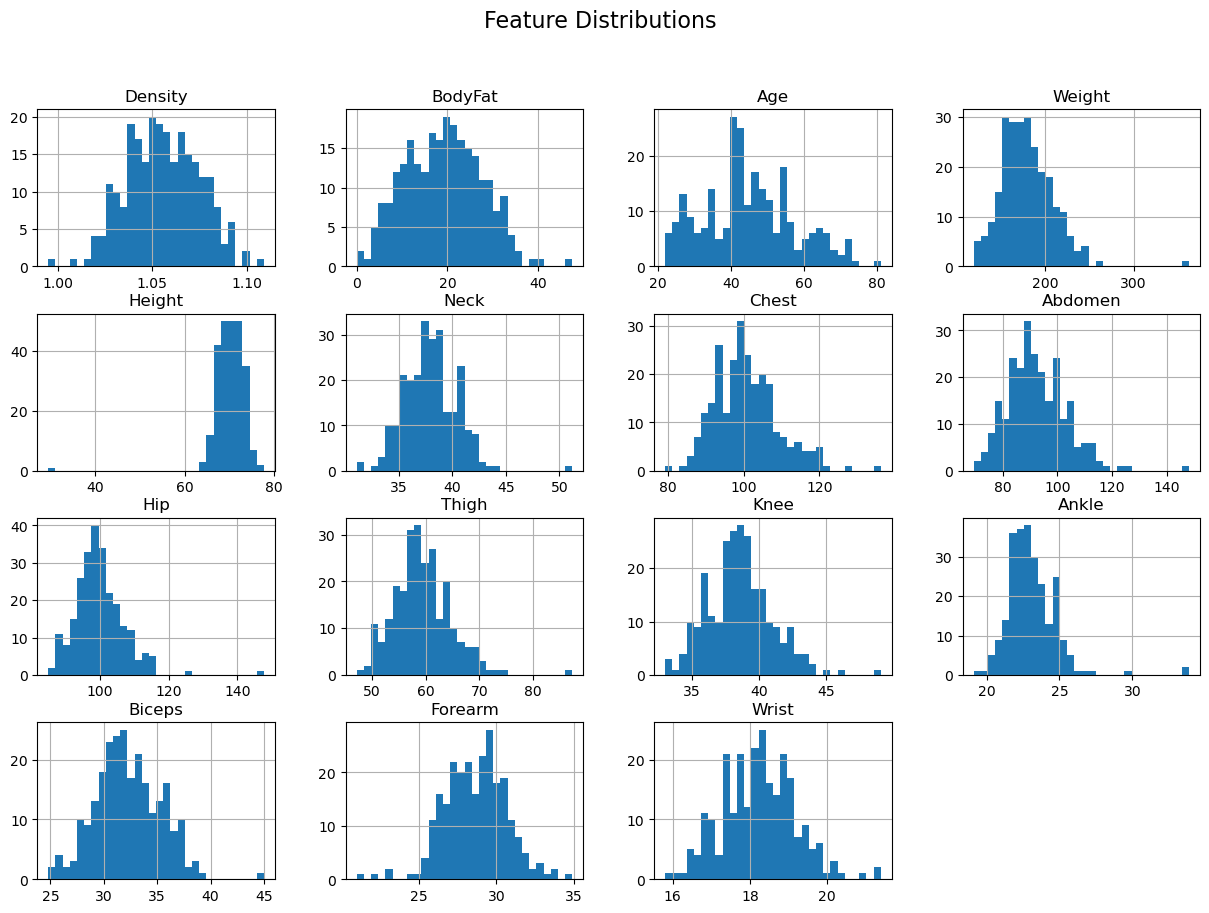

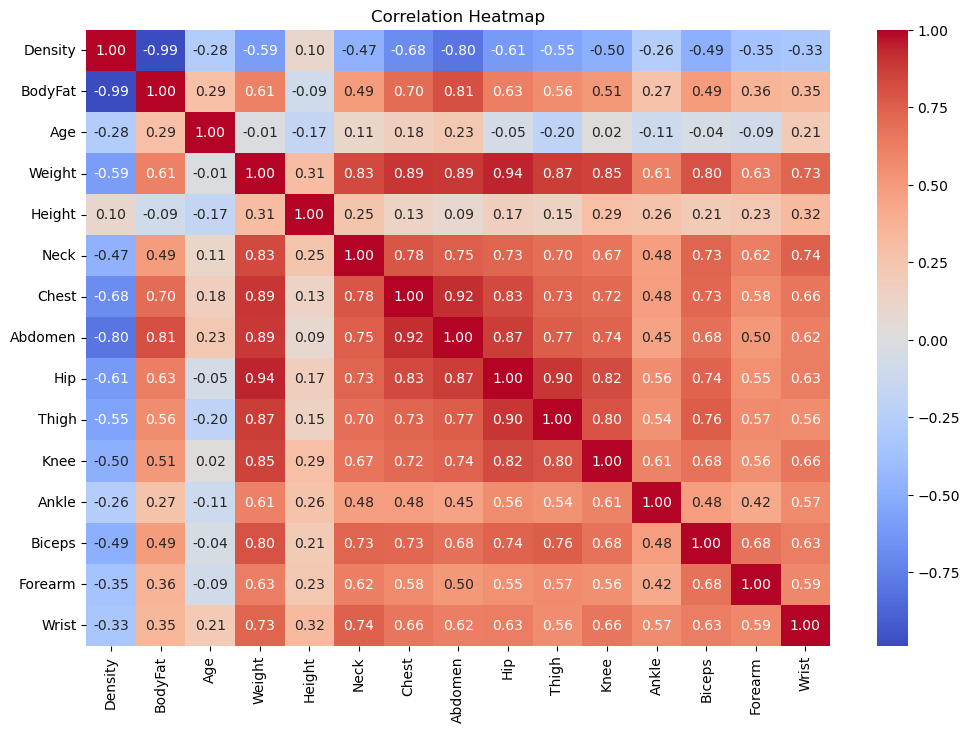

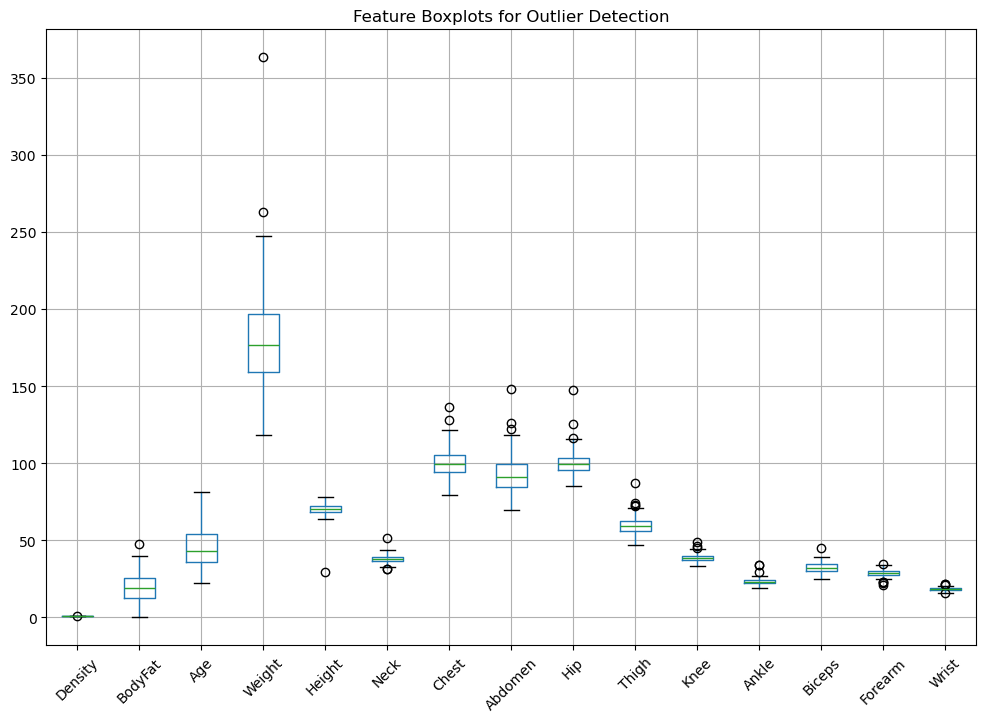

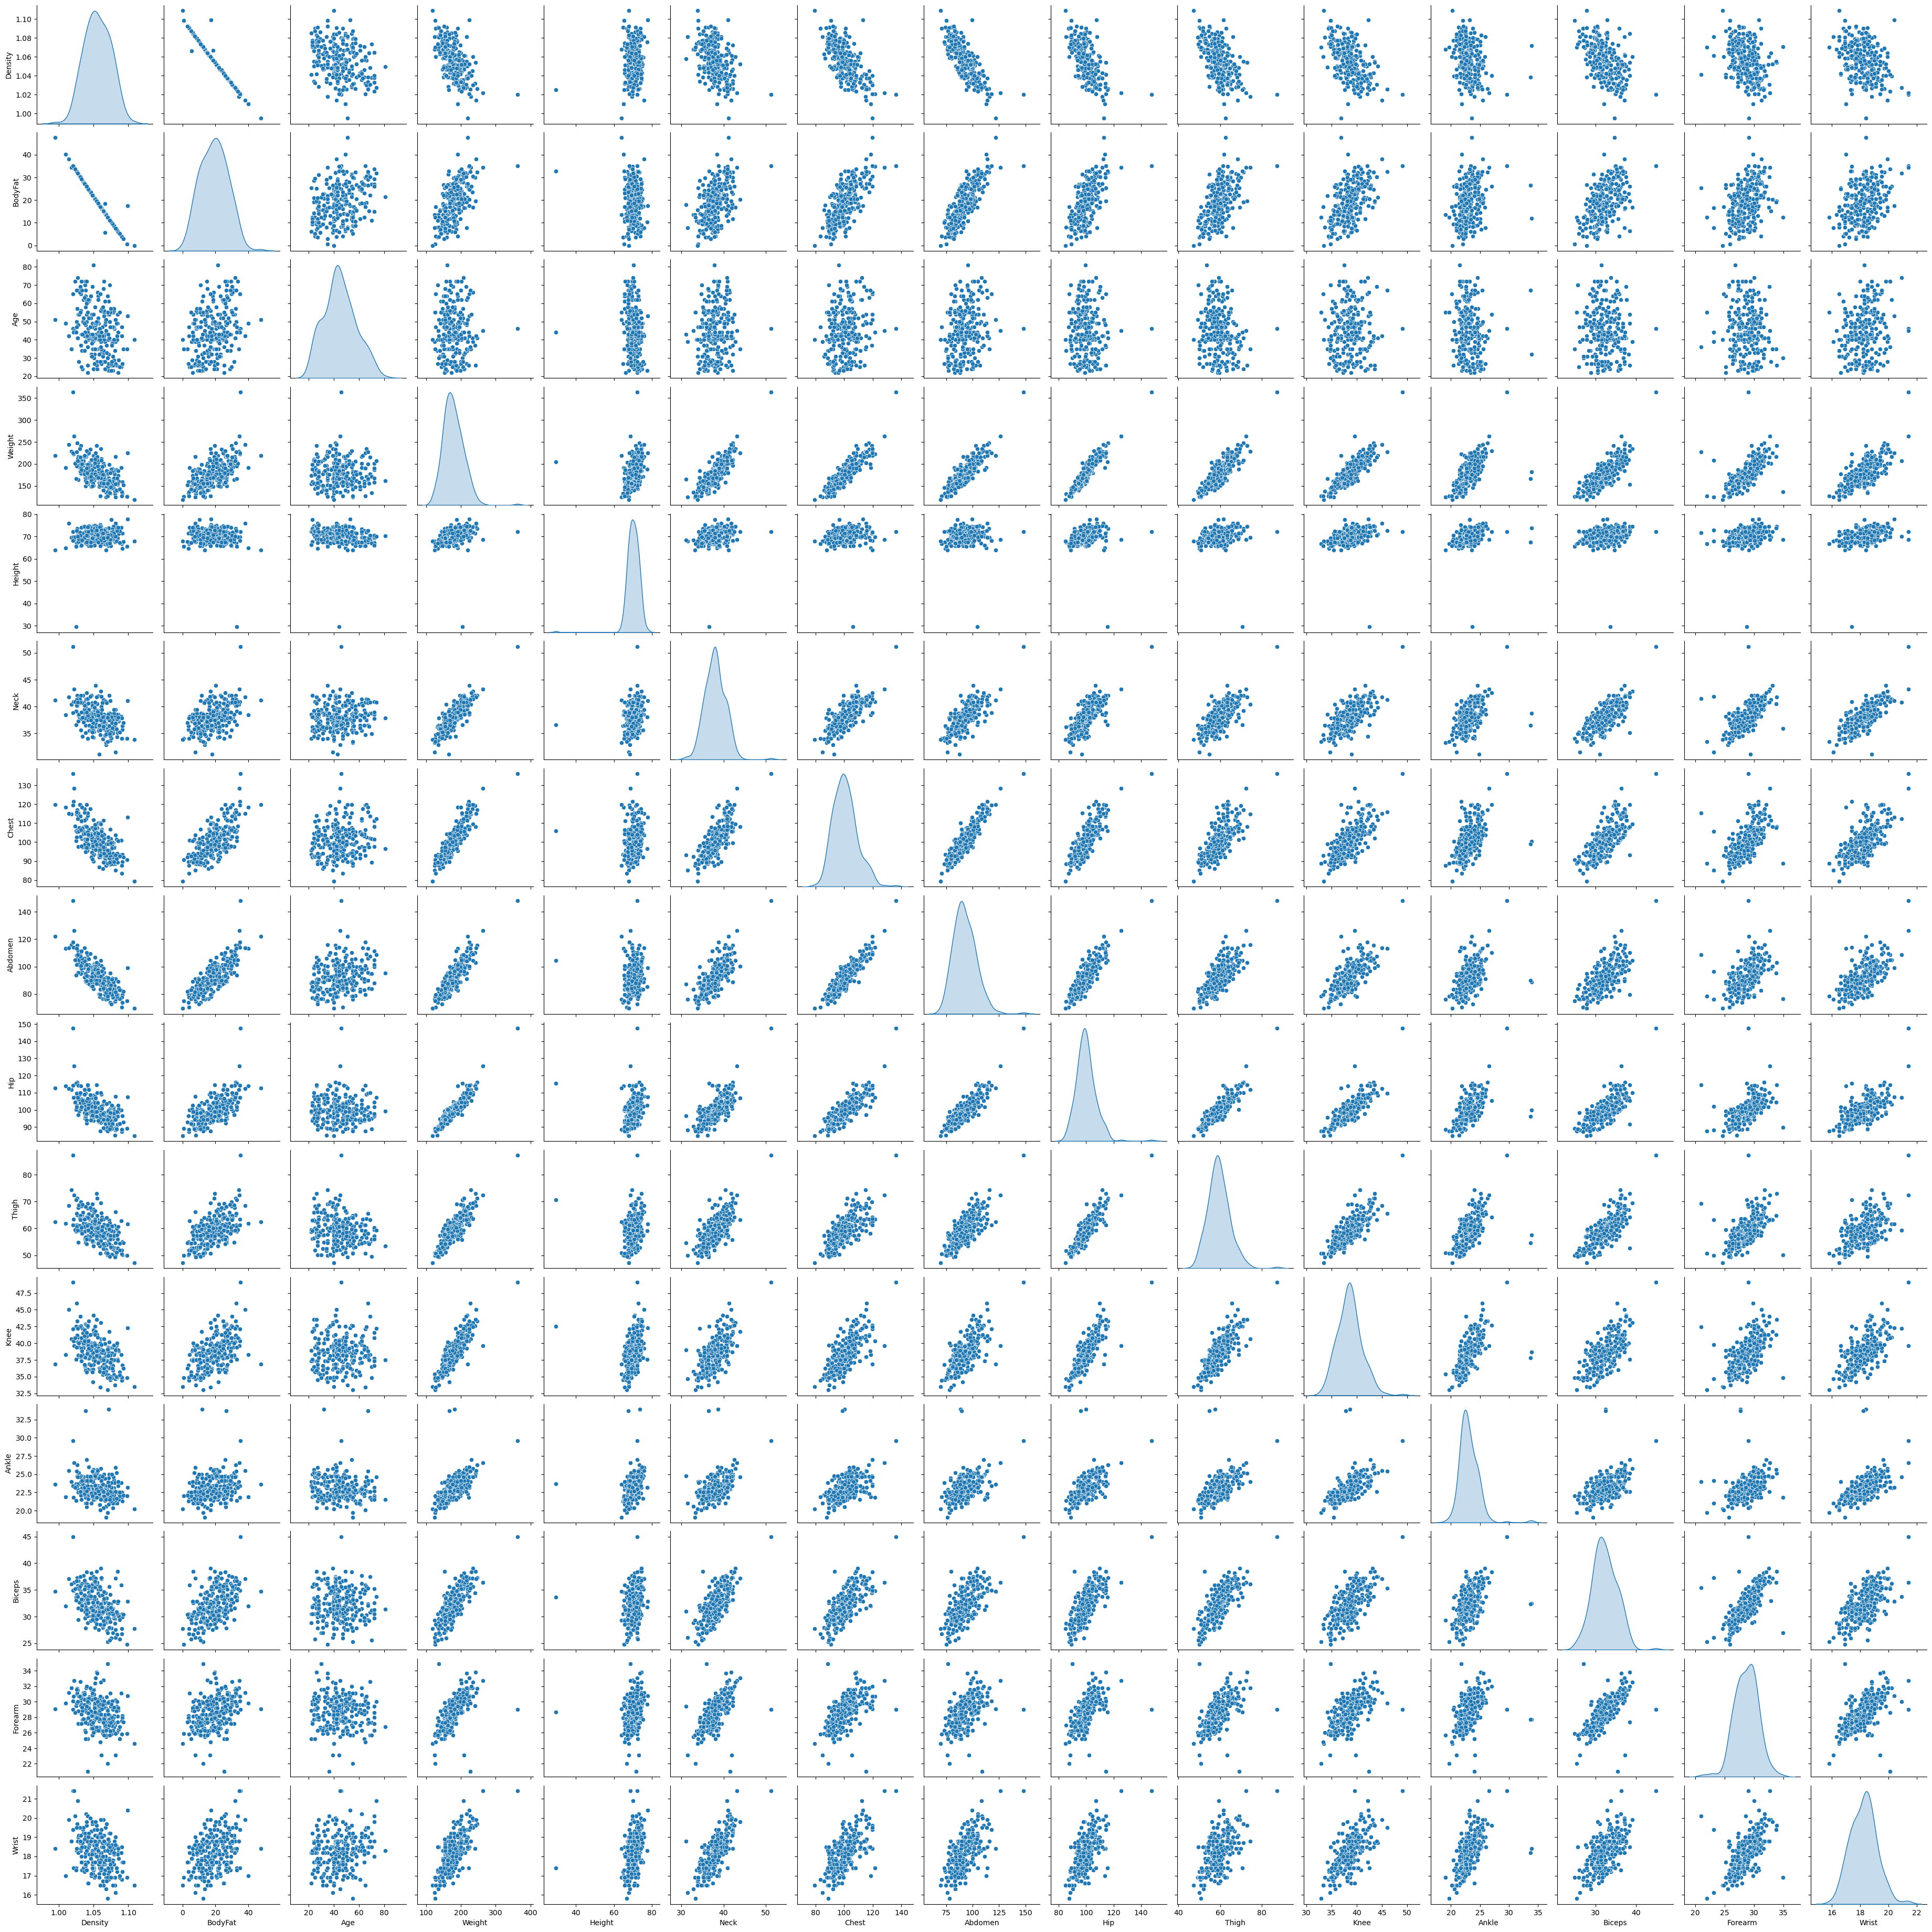

EDA completed!


In [ ]:
# Import necessary libraries
import os                      # For file path operations
import polars as pl            # High-performance dataframe library
import matplotlib.pyplot as plt # For creating visualizations
import seaborn as sns          # Advanced visualization library built on matplotlib

# Define file paths for the dataset
DATASET_PATH = "C:/Users/AC/Projects/LeanAI/Project/data/kaggle_datasets/body_fat"
CSV_FILE = "bodyfat.csv"

# Load the dataset from CSV using Polars
df = pl.read_csv(os.path.join(DATASET_PATH, CSV_FILE))

# SECTION 1: BASIC DATAFRAME INSPECTION
# ---------------------------------------
# Display first few rows to understand data structure
display(df.head())
# Display last few rows to check for any inconsistencies
display(df.tail())
# Display random sample to get broader view of data
display(df.sample(5))
# Show schema information (column names and data types)
display(df.schema)
# Display column data types
display(df.dtypes)
# Show dimensions of dataframe (rows, columns)
display(df.shape)
# List all column names
display(df.columns)
# Count unique values in each column to identify categorical vs continuous
display(df.n_unique())
# Count non-null values per column
display(df.count())
# Check for duplicate rows
display(df.is_duplicated())
# Check if all rows are unique
display(df.is_unique())

# SECTION 2: NUMERICAL SUMMARIES
# ---------------------------------------
# Show minimum values for each column
display(df.min())
# Show maximum values for each column
display(df.max())
# Calculate mean (average) for each column
display(df.mean())
# Calculate median (middle value) for each column
display(df.median())
# Calculate standard deviation to understand data spread
display(df.std())
# Calculate variance for each column
display(df.var())
# Sum all values in each column
display(df.sum())
# Show unique values in each column
display(df.unique())

# Generate comprehensive summary statistics
display(df.describe())

# SECTION 3: DATA QUALITY CHECKS
# ---------------------------------------
# Check for missing values in each column
missing_values = df.null_count()
print("Missing values per column:\n", missing_values)

# SECTION 4: VISUALIZATION
# ---------------------------------------
# Convert to pandas for visualization compatibility
df_pandas = df.to_pandas()

# Create histograms for all numerical features
df_pandas.hist(figsize=(15, 10), bins=30)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

# Generate correlation heatmap to identify relationships between variables
plt.figure(figsize=(12, 8))
sns.heatmap(df_pandas.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Create boxplots to visualize distributions and detect outliers
plt.figure(figsize=(12, 8))
df_pandas.boxplot(rot=45)
plt.title("Feature Boxplots for Outlier Detection")
plt.show()

# Generate pairplots to visualize relationships between pairs of features
# with KDE (Kernel Density Estimation) plots on diagonal
sns.pairplot(df_pandas, diag_kind='kde')
plt.show()

# Indicate completion of EDA process
print("EDA completed!")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits


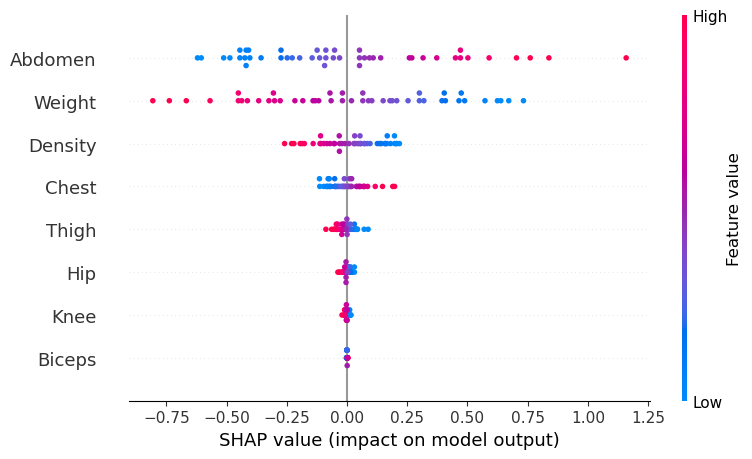

Model Evaluation Results:
                       MAE       MSE        R2     CV_R2
SVR               0.101193  0.016888  0.999687  0.962458
RandomForest      0.162761  0.053156  0.999015  0.958730
GradientBoosting  0.189490  0.072480  0.998657  0.957451
XGBoost           0.242488  0.113211  0.997902  0.955935
Lasso             0.423506  0.271270  0.994973  0.958115
LinearRegression  0.424213  0.302237  0.994399  0.956257
Ridge             0.471295  0.365133  0.993234  0.956529
AdaBoost          0.446810  0.482053  0.991067  0.950461
ElasticNet        0.570896  0.490207  0.990916  0.958440


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from scipy.stats import zscore
import shap
import joblib

# Load Data
df = pd.read_csv("data/kaggle_datasets/body_fat/bodyfat.csv")

# Drop non-numeric columns (if any, like ID columns)
df = df.select_dtypes(include=[np.number])

# Handle Missing Values
df.dropna(inplace=True)

# Outlier Detection and Removal using Z-score & IQR
z_scores = np.abs(zscore(df))
df = df[(z_scores < 3).all(axis=1)]
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df_cleaned = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Feature Selection using SelectKBest (Top Features)
X = df_cleaned.drop(columns=["BodyFat"])
y = df_cleaned["BodyFat"]
selector = SelectKBest(score_func=f_regression, k=8)
X_selected = selector.fit_transform(X, y)
selected_feature_names = X.columns[selector.get_support()]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X[selected_feature_names], y, test_size=0.2, random_state=42)

# Define Regression Models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "RandomForest": RandomForestRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "XGBoost": XGBRegressor(),
    "SVR": SVR()
}

# Hyperparameter grids specific to each model
param_grids = {
    "Ridge": {"regressor__alpha": [0.1, 1.0, 10]},
    "Lasso": {"regressor__alpha": [0.01, 0.1, 1]},
    "ElasticNet": {"regressor__alpha": [0.01, 0.1, 1], "regressor__l1_ratio": [0.2, 0.5, 0.8]},
    "RandomForest": {"regressor__n_estimators": [50, 100, 200], "regressor__max_depth": [None, 10, 20]},
    "GradientBoosting": {"regressor__n_estimators": [50, 100, 200], "regressor__learning_rate": [0.01, 0.1, 0.2]},
    "AdaBoost": {"regressor__n_estimators": [50, 100, 200], "regressor__learning_rate": [0.01, 0.1, 0.2]},
    "XGBoost": {"regressor__n_estimators": [50, 100, 200], "regressor__learning_rate": [0.01, 0.1, 0.2], "regressor__max_depth": [3, 5, 7]},
    "SVR": {"regressor__C": [0.1, 1, 10], "regressor__kernel": ["linear", "rbf"]}
}

results = {}
best_models = {}

for name, model in models.items():
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", model)
    ])
    
    if name in param_grids:
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring="r2", n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
    else:
        best_model = pipeline.fit(X_train, y_train)
    
    # Cross-validation score
    cv_score = cross_val_score(best_model, X_train, y_train, cv=5, scoring="r2", n_jobs=-1).mean()
    
    # Predictions
    y_pred = best_model.predict(X_test)
    
    # Evaluate model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {"MAE": mae, "MSE": mse, "R2": r2, "CV_R2": cv_score}
    best_models[name] = best_model

# Convert results to DataFrame
results_df = pd.DataFrame(results).T

# Train final model (best performing one based on R2 score)
best_model_name = results_df["R2"].idxmax()
final_model = best_models[best_model_name]

# Create pipeline for the best model
final_pipeline = Pipeline([("scaler", StandardScaler()), ("regressor", final_model.named_steps["regressor"])])
final_pipeline.fit(X[selected_feature_names], y)

# Save final model
joblib.dump(final_pipeline, "bodyfat_model.pkl")

# SHAP for Model Explainability (Feature Importance)
explainer = shap.Explainer(final_model.named_steps["regressor"], X_train)
shap_values = explainer(X_test)

# Display Results & Feature Importance
shap.summary_plot(shap_values, X_test, feature_names=selected_feature_names)

# Display model evaluation results
print("Model Evaluation Results:")
print(results_df.sort_values(by="R2", ascending=False))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits


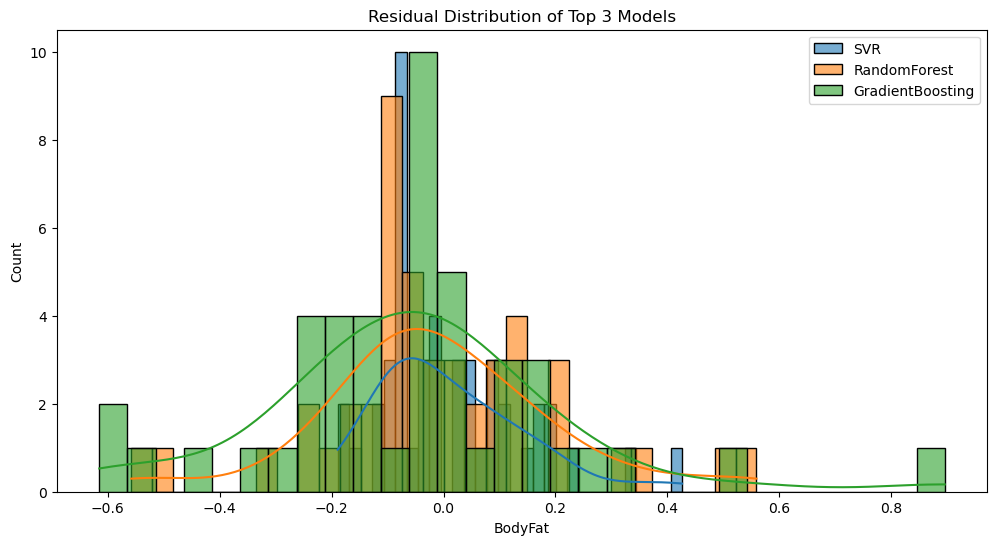

Model Evaluation Results:
                       MAE       MSE        R2     CV_R2
SVR               0.101193  0.016888  0.999687  0.962458
RandomForest      0.153304  0.043790  0.999189  0.960850
GradientBoosting  0.187504  0.070277  0.998698  0.959077
XGBoost           0.242488  0.113211  0.997902  0.955935
Lasso             0.423506  0.271270  0.994973  0.958115
LinearRegression  0.424213  0.302237  0.994399  0.956257
Ridge             0.471295  0.365133  0.993234  0.956529
ElasticNet        0.570896  0.490207  0.990916  0.958440
AdaBoost          0.553401  0.736671  0.986349  0.945299


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from scipy.stats import zscore
import shap
import joblib

# Ensure tqdm works properly
try:
    import ipywidgets
except ImportError:
    import subprocess
    subprocess.run(["pip", "install", "ipywidgets"])

# Load Data
df = pd.read_csv("data/kaggle_datasets/body_fat/bodyfat.csv")

# Drop non-numeric columns (if any, like ID columns)
df = df.select_dtypes(include=[np.number])

# Handle Missing Values
df.dropna(inplace=True)

# Outlier Detection and Removal using Z-score & IQR
z_scores = np.abs(zscore(df))
df = df[(z_scores < 3).all(axis=1)]
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df_cleaned = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Feature Selection using SelectKBest (Top Features)
X = df_cleaned.drop(columns=["BodyFat"])
y = df_cleaned["BodyFat"]
selector = SelectKBest(score_func=f_regression, k=8)
X_selected = selector.fit_transform(X, y)
selected_feature_names = X.columns[selector.get_support()]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X[selected_feature_names], y, test_size=0.2, random_state=42)

# Define Regression Models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "RandomForest": RandomForestRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "XGBoost": XGBRegressor(),
    "SVR": SVR()
}

# Hyperparameter grids specific to each model
param_grids = {
    "Ridge": {"regressor__alpha": [0.1, 1.0, 10]},
    "Lasso": {"regressor__alpha": [0.01, 0.1, 1]},
    "ElasticNet": {"regressor__alpha": [0.01, 0.1, 1], "regressor__l1_ratio": [0.2, 0.5, 0.8]},
    "RandomForest": {"regressor__n_estimators": [50, 100, 200], "regressor__max_depth": [None, 10, 20]},
    "GradientBoosting": {"regressor__n_estimators": [50, 100, 200], "regressor__learning_rate": [0.01, 0.1, 0.2]},
    "AdaBoost": {"regressor__n_estimators": [50, 100, 200], "regressor__learning_rate": [0.01, 0.1, 0.2]},
    "XGBoost": {"regressor__n_estimators": [50, 100, 200], "regressor__learning_rate": [0.01, 0.1, 0.2], "regressor__max_depth": [3, 5, 7]},
    "SVR": {"regressor__C": [0.1, 1, 10], "regressor__kernel": ["linear", "rbf"]}
}

results = {}
best_models = {}

for name, model in models.items():
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", model)
    ])
    
    if name in param_grids:
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring="r2", n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
    else:
        best_model = pipeline.fit(X_train, y_train)
    
    # Cross-validation score
    cv_score = cross_val_score(best_model, X_train, y_train, cv=5, scoring="r2", n_jobs=-1).mean()
    
    # Predictions
    y_pred = best_model.predict(X_test)
    
    # Evaluate model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {"MAE": mae, "MSE": mse, "R2": r2, "CV_R2": cv_score}
    best_models[name] = best_model

# Convert results to DataFrame
results_df = pd.DataFrame(results).T

# Select top 3 models
top_3_models = results_df.nlargest(3, "R2").index.tolist()

# Visualizing residuals for top 3 models
plt.figure(figsize=(12, 6))
for model_name in top_3_models:
    y_pred = best_models[model_name].predict(X_test)
    residuals = y_test - y_pred
    sns.histplot(residuals, kde=True, label=model_name, bins=30, alpha=0.6)
plt.legend()
plt.title("Residual Distribution of Top 3 Models")
plt.show()

# Save the best performing model
best_model_name = top_3_models[0]
final_model = best_models[best_model_name]
final_pipeline = Pipeline([("scaler", StandardScaler()), ("regressor", final_model.named_steps["regressor"])])
final_pipeline.fit(X[selected_feature_names], y)
joblib.dump(final_pipeline, "bodyfat_model.pkl")

# Display model evaluation results
print("Model Evaluation Results:")
print(results_df.sort_values(by="R2", ascending=False))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits


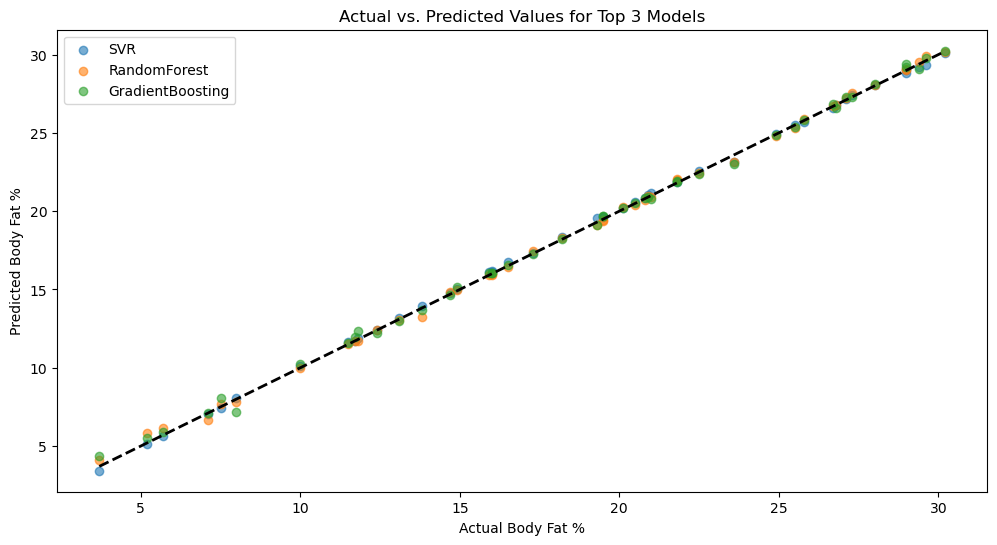

Model Evaluation Results:
                       MAE       MSE        R2     CV_R2
SVR               0.114541  0.020156  0.999626  0.962931
RandomForest      0.154014  0.047149  0.999126  0.959548
GradientBoosting  0.189803  0.070128  0.998700  0.958461
XGBoost           0.242488  0.113211  0.997902  0.955935
Lasso             0.423506  0.271270  0.994973  0.958115
LinearRegression  0.424213  0.302237  0.994399  0.956257
AdaBoost          0.406387  0.333343  0.993823  0.945318
Ridge             0.471295  0.365133  0.993234  0.956529
ElasticNet        0.570896  0.490207  0.990916  0.958440


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from scipy.stats import zscore
import shap
import joblib

# Load Data
df = pd.read_csv("data/kaggle_datasets/body_fat/bodyfat.csv")

# Drop non-numeric columns (if any, like ID columns)
df = df.select_dtypes(include=[np.number])

# Handle Missing Values
df.dropna(inplace=True)

# Outlier Detection and Removal using Z-score & IQR
z_scores = np.abs(zscore(df))
df = df[(z_scores < 3).all(axis=1)]
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df_cleaned = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Feature Selection using SelectKBest (Top Features)
X = df_cleaned.drop(columns=["BodyFat"])
y = df_cleaned["BodyFat"]
selector = SelectKBest(score_func=f_regression, k=8)
X_selected = selector.fit_transform(X, y)
selected_feature_names = X.columns[selector.get_support()]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X[selected_feature_names], y, test_size=0.2, random_state=42)

# Define Regression Models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "RandomForest": RandomForestRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "XGBoost": XGBRegressor(),
    "SVR": SVR()
}

# Hyperparameter grids specific to each model
param_grids = {
    "Ridge": {"regressor__alpha": [0.1, 1.0, 10]},
    "Lasso": {"regressor__alpha": [0.01, 0.1, 1]},
    "ElasticNet": {"regressor__alpha": [0.01, 0.1, 1], "regressor__l1_ratio": [0.2, 0.5, 0.8]},
    "RandomForest": {"regressor__n_estimators": [50, 100, 200], "regressor__max_depth": [None, 10, 20]},
    "GradientBoosting": {"regressor__n_estimators": [50, 100, 200], "regressor__learning_rate": [0.01, 0.1, 0.2]},
    "AdaBoost": {"regressor__n_estimators": [50, 100, 200], "regressor__learning_rate": [0.01, 0.1, 0.2]},
    "XGBoost": {"regressor__n_estimators": [50, 100, 200], "regressor__learning_rate": [0.01, 0.1, 0.2], "regressor__max_depth": [3, 5, 7]},
    "SVR": {"regressor__C": [0.1, 1, 10, 50], "regressor__epsilon": [0.01, 0.1, 0.2], "regressor__kernel": ["linear", "rbf"]}
}

results = {}
best_models = {}

for name, model in models.items():
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", model)
    ])
    
    if name in param_grids:
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring="r2", n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
    else:
        best_model = pipeline.fit(X_train, y_train)
    
    # Cross-validation score
    cv_score = cross_val_score(best_model, X_train, y_train, cv=5, scoring="r2", n_jobs=-1).mean()
    
    # Predictions
    y_pred = best_model.predict(X_test)
    
    # Evaluate model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {"MAE": mae, "MSE": mse, "R2": r2, "CV_R2": cv_score}
    best_models[name] = best_model

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df.to_csv("model_evaluation_results.csv", index=True)

# Select top 3 models
top_3_models = results_df.nlargest(3, "R2").index.tolist()

# Visualizing actual vs predicted for top 3 models
plt.figure(figsize=(12, 6))
for model_name in top_3_models:
    y_pred = best_models[model_name].predict(X_test)
    plt.scatter(y_test, y_pred, alpha=0.6, label=model_name)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Body Fat %")
plt.ylabel("Predicted Body Fat %")
plt.legend()
plt.title("Actual vs. Predicted Values for Top 3 Models")
plt.show()

# Save the best performing model
best_model_name = top_3_models[0]
final_model = best_models[best_model_name]
final_pipeline = Pipeline([("scaler", StandardScaler()), ("regressor", final_model.named_steps["regressor"])])
final_pipeline.fit(X[selected_feature_names], y)
joblib.dump(final_pipeline, "bodyfat_model.pkl")

# Display model evaluation results
print("Model Evaluation Results:")
print(results_df.sort_values(by="R2", ascending=False))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from scipy.stats import zscore
import shap
import joblib

# Load Data
df = pd.read_csv("data/kaggle_datasets/body_fat/bodyfat.csv")

# Drop non-numeric columns (if any, like ID columns)
df = df.select_dtypes(include=[np.number])

# Handle Missing Values
df.dropna(inplace=True)

# Outlier Detection and Removal using Z-score & IQR
z_scores = np.abs(zscore(df))
df = df[(z_scores < 3).all(axis=1)]
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df_cleaned = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Feature Selection using SelectKBest (Top Features)
X = df_cleaned.drop(columns=["BodyFat"])
y = df_cleaned["BodyFat"]
selector = SelectKBest(score_func=f_regression, k=8)
X_selected = selector.fit_transform(X, y)
selected_feature_names = X.columns[selector.get_support()]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X[selected_feature_names], y, test_size=0.2, random_state=42)

# Define Regression Models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "RandomForest": RandomForestRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "XGBoost": XGBRegressor(),
    "SVR": SVR()
}

# Hyperparameter grids specific to each model
param_grids = {
    "Ridge": {"regressor__alpha": [0.1, 1.0, 10]},
    "Lasso": {"regressor__alpha": [0.01, 0.1, 1]},
    "ElasticNet": {"regressor__alpha": [0.01, 0.1, 1], "regressor__l1_ratio": [0.2, 0.5, 0.8]},
    "RandomForest": {"regressor__n_estimators": [50, 100, 200], "regressor__max_depth": [None, 10, 20]},
    "GradientBoosting": {"regressor__n_estimators": [50, 100, 200], "regressor__learning_rate": [0.01, 0.1, 0.2]},
    "AdaBoost": {"regressor__n_estimators": [50, 100, 200], "regressor__learning_rate": [0.01, 0.1, 0.2]},
    "XGBoost": {"regressor__n_estimators": [50, 100, 200], "regressor__learning_rate": [0.01, 0.1, 0.2], "regressor__max_depth": [3, 5, 7]},
    "SVR": {"regressor__C": [0.1, 1, 10, 50], "regressor__epsilon": [0.01, 0.1, 0.2], "regressor__kernel": ["linear", "rbf"]}
}

results = {}
best_models = {}

for name, model in models.items():
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", model)
    ])
    
    if name in param_grids:
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring="r2", n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
    else:
        best_model = pipeline.fit(X_train, y_train)
    
    # Cross-validation score
    cv_score = cross_val_score(best_model, X_train, y_train, cv=5, scoring="r2", n_jobs=-1).mean()
    
    # Predictions
    y_pred = best_model.predict(X_test)
    
    # Evaluate model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {"MAE": mae, "MSE": mse, "R2": r2, "CV_R2": cv_score}
    best_models[name] = best_model

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df.to_csv("model_evaluation_results.csv", index=True)

# Train and evaluate a simple Linear Regression model
simple_model = LinearRegression()
simple_model.fit(X_train, y_train)
simple_y_pred = simple_model.predict(X_test)
simple_r2 = r2_score(y_test, simple_y_pred)
print(f"Simple Linear Regression R²: {simple_r2}")

# Compare simple model with the best model
best_model_name = results_df["R2"].idxmax()
best_model = best_models[best_model_name]
best_y_pred = best_model.predict(X_test)
best_r2 = r2_score(y_test, best_y_pred)
print(f"Best Model ({best_model_name}) R²: {best_r2}")

# Save the best performing model
final_pipeline = Pipeline([("scaler", StandardScaler()), ("regressor", best_model.named_steps["regressor"])])
final_pipeline.fit(X[selected_feature_names], y)
joblib.dump(final_pipeline, "bodyfat_model.pkl")

# Display model evaluation results
print("Model Evaluation Results:")
print(results_df.sort_values(by="R2", ascending=False))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Simple Linear Regression R²: 0.9943991829977575
Best Model (SVR) R²: 0.9996264817016391
Model Evaluation Results:
                       MAE       MSE        R2     CV_R2
SVR               0.114541  0.020156  0.999626  0.962931
RandomForest      0.166478  0.056879  0.998946  0.959204
GradientBoosting  0.191152  0.070397  0.998695  0.957644
XGBoost           0.242488  0.113211  0.997902  0.955935
Lasso             0.423506  0.271270  0.994973  0.958115
LinearRegression  0.424213  0.302237  0.994399  0.956257
Rid

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score
from sklearn.feature_selection import SelectKBest, f_regression
from scipy.stats import zscore
import shap
import joblib

# Ensure tqdm works properly
try:
    import ipywidgets
except ImportError:
    import subprocess
    subprocess.run(["pip", "install", "ipywidgets"])

# Load Data
df = pd.read_csv("data/kaggle_datasets/body_fat/bodyfat.csv")

# Drop non-numeric columns (if any, like ID columns)
df = df.select_dtypes(include=[np.number])

# Handle Missing Values
df.dropna(inplace=True)

# Outlier Detection and Removal using Z-score & IQR
z_scores = np.abs(zscore(df))
df = df[(z_scores < 3).all(axis=1)]
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df_cleaned = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Feature Selection using SelectKBest (Top Features)
X = df_cleaned.drop(columns=["BodyFat"])
y = df_cleaned["BodyFat"]
selector = SelectKBest(score_func=f_regression, k=8)
X_selected = selector.fit_transform(X, y)
selected_feature_names = X.columns[selector.get_support()]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X[selected_feature_names], y, test_size=0.2, random_state=42)

# Define Regression Models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "RandomForest": RandomForestRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "XGBoost": XGBRegressor(),
    "SVR": SVR()
}

# Train and evaluate a simple Linear Regression model
simple_model = LinearRegression()
simple_model.fit(X_train, y_train)
simple_y_pred = simple_model.predict(X_test)
simple_r2 = r2_score(y_test, simple_y_pred)
simple_mape = mean_absolute_percentage_error(y_test, simple_y_pred)
simple_var = explained_variance_score(y_test, simple_y_pred)
print(f"Simple Linear Regression R²: {simple_r2}")
print(f"Simple Linear Regression MAPE: {simple_mape}")
print(f"Simple Linear Regression Explained Variance: {simple_var}")

# Hyperparameter grids specific to each model
param_grids = {
    "Ridge": {"regressor__alpha": [0.1, 1.0, 10]},
    "Lasso": {"regressor__alpha": [0.01, 0.1, 1]},
    "ElasticNet": {"regressor__alpha": [0.01, 0.1, 1], "regressor__l1_ratio": [0.2, 0.5, 0.8]},
    "RandomForest": {"regressor__n_estimators": [50, 100, 200], "regressor__max_depth": [None, 10, 20]},
    "GradientBoosting": {"regressor__n_estimators": [50, 100, 200], "regressor__learning_rate": [0.01, 0.1, 0.2]},
    "AdaBoost": {"regressor__n_estimators": [50, 100, 200], "regressor__learning_rate": [0.01, 0.1, 0.2]},
    "XGBoost": {"regressor__n_estimators": [50, 100, 200], "regressor__learning_rate": [0.01, 0.1, 0.2], "regressor__max_depth": [3, 5, 7]},
    "SVR": {"regressor__C": [0.1, 1, 10, 50], "regressor__epsilon": [0.01, 0.1, 0.2], "regressor__kernel": ["linear", "rbf"]}
}

results = {}
best_models = {}

for name, model in models.items():
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", model)
    ])
    
    if name in param_grids:
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring="r2", n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
    else:
        best_model = pipeline.fit(X_train, y_train)
    
    # Predictions
    y_pred = best_model.predict(X_test)
    
    # Evaluate model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    var_exp = explained_variance_score(y_test, y_pred)
    
    results[name] = {"MAE": mae, "MSE": mse, "R2": r2, "MAPE": mape, "Explained Variance": var_exp}
    best_models[name] = best_model

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df.to_csv("model_evaluation_results.csv", index=True)

# Compare simple model with the best model
best_model_name = results_df["R2"].idxmax()
best_model = best_models[best_model_name]
best_y_pred = best_model.predict(X_test)
best_r2 = r2_score(y_test, best_y_pred)
print(f"Best Model ({best_model_name}) R²: {best_r2}")

# Save the best performing model
final_pipeline = Pipeline([("scaler", StandardScaler()), ("regressor", best_model.named_steps["regressor"])])
final_pipeline.fit(X[selected_feature_names], y)
joblib.dump(final_pipeline, "bodyfat_model.pkl")

# Display model evaluation results
print("Model Evaluation Results:")
print(results_df.sort_values(by="R2", ascending=False))

Simple Linear Regression R²: 0.9943991829977575
Simple Linear Regression MAPE: 0.028793547276399194
Simple Linear Regression Explained Variance: 0.9944217199505746
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Model (SVR) R²: 0.9996264817016391
Model Evaluation Results:
                       MAE       MSE        R2      MAPE  Explained Variance
SVR               0.114541  0.020156  0.999626  0.008014            0.999643
RandomForest      0.151522  0.058445  0.998917  0.014145            0.998954
GradientBoosting  0.192854  0.072471  0.998657  0.01771

Simple Linear Regression R²: 0.9943991829977575
Simple Linear Regression MAPE: 0.028793547276399194
Simple Linear Regression Explained Variance: 0.9944217199505746


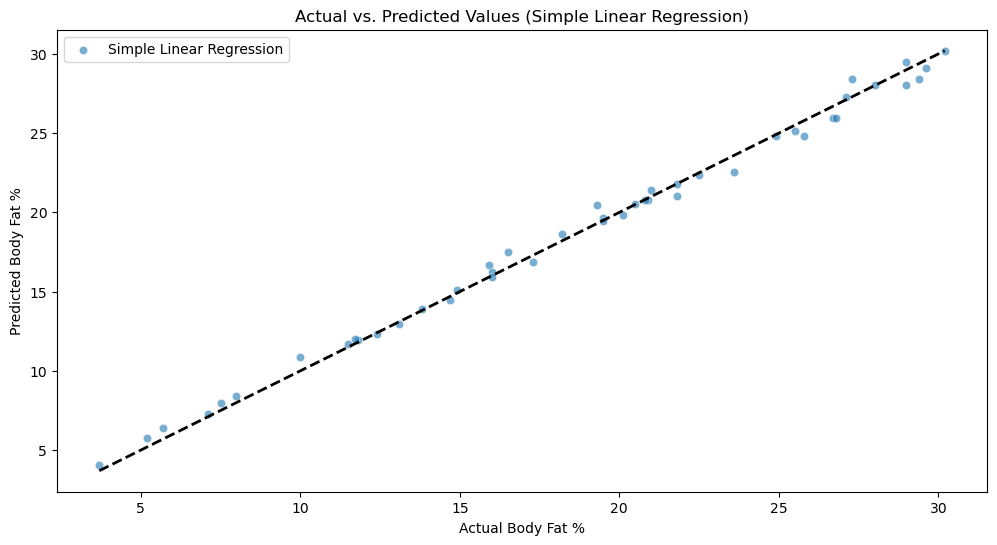

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Model Evaluation Results:
                       MAE       MSE        R2      MAPE  Explained Variance
SVR               0.114541  0.020156  0.999626  0.008014            0.999643
RandomForest      0.184457  0.072078  0.998664  0.016423            0.998694
GradientBoosting  0.190411  0.074027  0.998628  0.017850            0.998671
XGBoost           0.242488  0.113211  0.997902  0.020777            0.998263
Lasso             0.423506  0.271270  0.994973  0.031183            0.995028
LinearRegression  0.424213  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score
from sklearn.feature_selection import SelectKBest, f_regression
from scipy.stats import zscore
import shap
import joblib

# # Ensure tqdm works properly
# try:
#     import ipywidgets
# except ImportError:
#     import subprocess
#     subprocess.run(["pip", "install", "ipywidgets"])

# Load Data
df = pd.read_csv("data/kaggle_datasets/body_fat/bodyfat.csv")

# Drop non-numeric columns (if any, like ID columns)
df = df.select_dtypes(include=[np.number])

# Handle Missing Values
df.dropna(inplace=True)

# Outlier Detection and Removal using Z-score & IQR
z_scores = np.abs(zscore(df))
df = df[(z_scores < 3).all(axis=1)]
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df_cleaned = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Feature Selection using SelectKBest (Top Features)
X = df_cleaned.drop(columns=["BodyFat"])
y = df_cleaned["BodyFat"]
selector = SelectKBest(score_func=f_regression, k=8)
X_selected = selector.fit_transform(X, y)
selected_feature_names = X.columns[selector.get_support()]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X[selected_feature_names], y, test_size=0.2, random_state=42)

# Define Regression Models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "RandomForest": RandomForestRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "XGBoost": XGBRegressor(),
    "SVR": SVR()
}

# Train and evaluate a simple Linear Regression model
simple_model = LinearRegression()
simple_model.fit(X_train, y_train)
simple_y_pred = simple_model.predict(X_test)
simple_r2 = r2_score(y_test, simple_y_pred)
simple_mape = mean_absolute_percentage_error(y_test, simple_y_pred)
simple_var = explained_variance_score(y_test, simple_y_pred)
print(f"Simple Linear Regression R²: {simple_r2}")
print(f"Simple Linear Regression MAPE: {simple_mape}")
print(f"Simple Linear Regression Explained Variance: {simple_var}")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test, y=simple_y_pred, alpha=0.6, label="Simple Linear Regression")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Body Fat %")
plt.ylabel("Predicted Body Fat %")
plt.legend()
plt.title("Actual vs. Predicted Values (Simple Linear Regression)")
plt.show()

# Hyperparameter grids specific to each model
param_grids = {
    "Ridge": {"regressor__alpha": [0.1, 1.0, 10]},
    "Lasso": {"regressor__alpha": [0.01, 0.1, 1]},
    "ElasticNet": {"regressor__alpha": [0.01, 0.1, 1], "regressor__l1_ratio": [0.2, 0.5, 0.8]},
    "RandomForest": {"regressor__n_estimators": [50, 100, 200], "regressor__max_depth": [None, 10, 20]},
    "GradientBoosting": {"regressor__n_estimators": [50, 100, 200], "regressor__learning_rate": [0.01, 0.1, 0.2]},
    "AdaBoost": {"regressor__n_estimators": [50, 100, 200], "regressor__learning_rate": [0.01, 0.1, 0.2]},
    "XGBoost": {"regressor__n_estimators": [50, 100, 200], "regressor__learning_rate": [0.01, 0.1, 0.2], "regressor__max_depth": [3, 5, 7]},
    "SVR": {"regressor__C": [0.1, 1, 10, 50], "regressor__epsilon": [0.01, 0.1, 0.2], "regressor__kernel": ["linear", "rbf"]}
}

results = {}
best_models = {}

for name, model in models.items():
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", model)
    ])
    
    if name in param_grids:
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring="r2", n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
    else:
        best_model = pipeline.fit(X_train, y_train)
    
    # Predictions
    y_pred = best_model.predict(X_test)
    
    # Evaluate model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    var_exp = explained_variance_score(y_test, y_pred)
    
    results[name] = {"MAE": mae, "MSE": mse, "R2": r2, "MAPE": mape, "Explained Variance": var_exp}
    best_models[name] = best_model

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df.to_csv("model_evaluation_results.csv", index=True)

# Display model evaluation results
print("Model Evaluation Results:")
print(results_df.sort_values(by="R2", ascending=False))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.decomposition import PCA
from scipy.stats import zscore
import shap
import joblib

# Ensure tqdm works properly
try:
    import ipywidgets
except ImportError:
    import subprocess
    subprocess.run(["pip", "install", "ipywidgets"])

# Load Data
df = pd.read_csv("data/kaggle_datasets/body_fat/bodyfat.csv")

# Drop non-numeric columns (if any, like ID columns)
df = df.select_dtypes(include=[np.number])

# Handle Missing Values
df.dropna(inplace=True)

# Outlier Detection and Removal using Z-score & IQR
z_scores = np.abs(zscore(df))
df = df[(z_scores < 3).all(axis=1)]
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df_cleaned = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Feature Engineering - Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(df_cleaned.drop(columns=["BodyFat"]))

# Feature Selection using Recursive Feature Elimination (RFE)
estimator = LinearRegression()
rfe = RFE(estimator, n_features_to_select=8)
X_selected = rfe.fit_transform(X_poly, df_cleaned["BodyFat"])
selected_feature_names = poly.get_feature_names_out(df_cleaned.drop(columns=["BodyFat"]).columns)[rfe.support_]

# PCA for Dimensionality Reduction
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_selected)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_pca, df_cleaned["BodyFat"], test_size=0.2, random_state=42)

# Define Regression Models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "RandomForest": RandomForestRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "XGBoost": XGBRegressor(),
    "SVR": SVR(),
    "MLPRegressor": MLPRegressor(hidden_layer_sizes=(100,50), max_iter=2000)
}

# Stacking Ensemble Model
stacking_regressor = StackingRegressor(
    estimators=[("rf", RandomForestRegressor()), ("gb", GradientBoostingRegressor()), ("svr", SVR())],
    final_estimator=LinearRegression()
)
models["StackingRegressor"] = stacking_regressor

# Hyperparameter grids specific to each model
param_grids = {
    "SVR": {"regressor__C": [0.1, 1, 10, 50], "regressor__epsilon": [0.01, 0.1, 0.2], "regressor__kernel": ["linear", "rbf"]},
    "RandomForest": {"regressor__n_estimators": [50, 100, 200], "regressor__max_depth": [None, 10, 20]},
    "GradientBoosting": {"regressor__n_estimators": [50, 100, 200], "regressor__learning_rate": [0.01, 0.1, 0.2]},
    "MLPRegressor": {"regressor__hidden_layer_sizes": [(100,), (50,50), (100,50)], "regressor__alpha": [0.0001, 0.001, 0.01]}
}

results = {}
best_models = {}

for name, model in models.items():
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", model)
    ])
    
    if name in param_grids:
        param_space = list(ParameterGrid(param_grids[name]))
        n_iter = min(len(param_space), 10)  # Dynamically adjust n_iter to avoid warnings
        search = RandomizedSearchCV(pipeline, param_grids[name], cv=5, scoring="r2", n_jobs=-1, verbose=1, n_iter=n_iter, random_state=42)
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
    else:
        best_model = pipeline.fit(X_train, y_train)
    
    # Predictions
    y_pred = best_model.predict(X_test)
    
    # Evaluate model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    var_exp = explained_variance_score(y_test, y_pred)
    
    results[name] = {"MAE": mae, "MSE": mse, "R2": r2, "MAPE": mape, "Explained Variance": var_exp}
    best_models[name] = best_model

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df.to_csv("model_evaluation_results.csv", index=True)

# Display model evaluation results
print("Model Evaluation Results:")
print(results_df.sort_values(by="R2", ascending=False))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\AC\Projects\Programs\UofT-DSI\env\.pixi\envs\default\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Model Evaluation Results:
                        MAE        MSE        R2      MAPE  Explained Variance
SVR                0.315097   0.163489  0.996970  0.027333            0.996972
MLPRegressor       0.395443   0.294750  0.994538  0.032204            0.994542
LinearRegression   0.506027   0.401387  0.992562  0.037945            0.992584
Ridge              0.525192   0.429619  0.992039  0.039954            0.992058
StackingRegressor  1.081414   1.697013  0.968552  0.080440            0.968553
GradientBoosting   1.241358   2.480202  0.954039  0.087141            0.954293
XGBoost            1.401571   3.879292  0.928112  0.097728            0.928525
RandomForest       1.762637   5.158090  0.904414  0.133033            0.904539
Lasso              2.070826   6.018619  0.888468  0.166688            0.889867
AdaBoost           2.007842   6.180199  0.885473  0.157119            0.886702
ElasticNet         2.861452  11.469599  0.787454  0.238231            0.788342


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.decomposition import PCA
from scipy.stats import zscore
import shap
import joblib

# Ensure tqdm works properly
try:
    import ipywidgets
except ImportError:
    import subprocess
    subprocess.run(["pip", "install", "ipywidgets"])

# Load Data
df = pd.read_csv("data/kaggle_datasets/body_fat/bodyfat.csv")

# Drop non-numeric columns (if any, like ID columns)
df = df.select_dtypes(include=[np.number])

# Handle Missing Values
df.dropna(inplace=True)

# Outlier Detection and Removal using Z-score & IQR
z_scores = np.abs(zscore(df))
df = df[(z_scores < 3).all(axis=1)]
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df_cleaned = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Feature Engineering - Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(df_cleaned.drop(columns=["BodyFat"]))

# Feature Selection using Recursive Feature Elimination (RFE)
estimator = LinearRegression()
rfe = RFE(estimator, n_features_to_select=8)
X_selected = rfe.fit_transform(X_poly, df_cleaned["BodyFat"])
selected_feature_names = poly.get_feature_names_out(df_cleaned.drop(columns=["BodyFat"]).columns)[rfe.support_]

# PCA for Dimensionality Reduction
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_selected)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_pca, df_cleaned["BodyFat"], test_size=0.2, random_state=42)

# Define Regression Models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "RandomForest": RandomForestRegressor(n_estimators=300, max_depth=25),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=300, learning_rate=0.05),
    "AdaBoost": AdaBoostRegressor(n_estimators=300, learning_rate=0.05),
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=7),
    "SVR": SVR(C=10, epsilon=0.01, kernel='rbf'),
    "MLPRegressor": MLPRegressor(hidden_layer_sizes=(200,100), max_iter=5000, alpha=0.0005)
}

# Stacking Ensemble Model
stacking_regressor = StackingRegressor(
    estimators=[("rf", RandomForestRegressor(n_estimators=200)), ("gb", GradientBoostingRegressor(n_estimators=200)), ("svr", SVR(C=10, epsilon=0.01))],
    final_estimator=XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=5)
)
models["StackingRegressor"] = stacking_regressor

# Train and evaluate models
results = {}
best_models = {}

for name, model in models.items():
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", model)
    ])
    
    best_model = pipeline.fit(X_train, y_train)
    
    # Predictions
    y_pred = best_model.predict(X_test)
    
    # Evaluate model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    var_exp = explained_variance_score(y_test, y_pred)
    
    results[name] = {"MAE": mae, "MSE": mse, "R2": r2, "MAPE": mape, "Explained Variance": var_exp}
    best_models[name] = best_model

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df.to_csv("model_evaluation_results.csv", index=True)

# Display model evaluation results
print("Model Evaluation Results:")
print(results_df.sort_values(by="R2", ascending=False))


Model Evaluation Results:
                        MAE        MSE        R2      MAPE  Explained Variance
MLPRegressor       0.306208   0.173208  0.996790  0.020226            0.996798
SVR                0.254364   0.182844  0.996612  0.020864            0.996623
LinearRegression   0.506027   0.401387  0.992562  0.037945            0.992584
Ridge              0.525192   0.429619  0.992039  0.039954            0.992058
StackingRegressor  0.648709   1.058675  0.980381  0.059201            0.981382
GradientBoosting   1.476801   3.465319  0.935783  0.103121            0.935981
XGBoost            1.393393   4.013423  0.925626  0.093648            0.925631
RandomForest       1.681710   4.578905  0.915147  0.126747            0.915325
Lasso              2.070826   6.018619  0.888468  0.166688            0.889867
AdaBoost           2.211294   7.381161  0.863218  0.173822            0.863763
ElasticNet         2.861452  11.469599  0.787454  0.238231            0.788342


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.decomposition import PCA
from scipy.stats import zscore
import shap
import joblib

# Ensure tqdm works properly
try:
    import ipywidgets
except ImportError:
    import subprocess
    subprocess.run(["pip", "install", "ipywidgets"])

# Load Data
df = pd.read_csv("data/kaggle_datasets/body_fat/bodyfat.csv")

# Drop non-numeric columns (if any, like ID columns)
df = df.select_dtypes(include=[np.number])

# Handle Missing Values
df.dropna(inplace=True)

# Outlier Detection and Removal using Z-score & IQR
z_scores = np.abs(zscore(df))
df = df[(z_scores < 3).all(axis=1)]
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df_cleaned = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Feature Engineering - Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(df_cleaned.drop(columns=["BodyFat"]))

# Feature Selection using Recursive Feature Elimination (RFE)
estimator = LinearRegression()
rfe = RFE(estimator, n_features_to_select=8)
X_selected = rfe.fit_transform(X_poly, df_cleaned["BodyFat"])
selected_feature_names = poly.get_feature_names_out(df_cleaned.drop(columns=["BodyFat"]).columns)[rfe.support_]

# PCA for Dimensionality Reduction
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_selected)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_pca, df_cleaned["BodyFat"], test_size=0.2, random_state=42)

# Define Regression Models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "RandomForest": RandomForestRegressor(n_estimators=400, max_depth=30),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=400, learning_rate=0.03),
    "AdaBoost": AdaBoostRegressor(n_estimators=400, learning_rate=0.03),
    "XGBoost": XGBRegressor(n_estimators=400, learning_rate=0.03, max_depth=8),
    "SVR": SVR(C=15, epsilon=0.005, kernel='rbf'),
    "MLPRegressor": MLPRegressor(hidden_layer_sizes=(300,150), max_iter=6000, alpha=0.0003)
}

# Stacking Ensemble Model
stacking_regressor = StackingRegressor(
    estimators=[("rf", RandomForestRegressor(n_estimators=250)), ("gb", GradientBoostingRegressor(n_estimators=250)), ("svr", SVR(C=15, epsilon=0.005))],
    final_estimator=MLPRegressor(hidden_layer_sizes=(150,75), max_iter=3000, alpha=0.0005)
)
models["StackingRegressor"] = stacking_regressor

# Train and evaluate models
results = {}
best_models = {}

for name, model in models.items():
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", model)
    ])
    
    best_model = pipeline.fit(X_train, y_train)
    
    # Predictions
    y_pred = best_model.predict(X_test)
    
    # Evaluate model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    var_exp = explained_variance_score(y_test, y_pred)
    
    results[name] = {"MAE": mae, "MSE": mse, "R2": r2, "MAPE": mape, "Explained Variance": var_exp}
    best_models[name] = best_model

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df.to_csv("model_evaluation_results.csv", index=True)

# Display model evaluation results
print("Model Evaluation Results:")
print(results_df.sort_values(by="R2", ascending=False))

Model Evaluation Results:
                        MAE        MSE        R2      MAPE  Explained Variance
MLPRegressor       0.281087   0.151695  0.997189  0.019753            0.997260
SVR                0.235456   0.155570  0.997117  0.019927            0.997128
LinearRegression   0.506027   0.401387  0.992562  0.037945            0.992584
Ridge              0.525192   0.429619  0.992039  0.039954            0.992058
GradientBoosting   1.299285   2.801682  0.948081  0.090322            0.948159
XGBoost            1.474662   4.207849  0.922023  0.094990            0.922029
RandomForest       1.761120   5.011619  0.907129  0.130436            0.907175
Lasso              2.070826   6.018619  0.888468  0.166688            0.889867
AdaBoost           2.440198   8.716920  0.838465  0.185632            0.838878
StackingRegressor  2.706391   9.030941  0.832646  0.185523            0.968379
ElasticNet         2.861452  11.469599  0.787454  0.238231            0.788342


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.decomposition import PCA
from scipy.stats import zscore
import shap
import joblib

# Load Data
df = pd.read_csv("data/kaggle_datasets/body_fat/bodyfat.csv")

# Drop non-numeric columns (if any, like ID columns)
df = df.select_dtypes(include=[np.number])

# Handle Missing Values
df.dropna(inplace=True)

# Outlier Detection and Removal using Z-score & IQR
z_scores = np.abs(zscore(df))
df = df[(z_scores < 3).all(axis=1)]
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df_cleaned = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Feature Engineering - Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(df_cleaned.drop(columns=["BodyFat"]))

# Feature Selection using Recursive Feature Elimination (RFE)
estimator = LinearRegression()
rfe = RFE(estimator, n_features_to_select=8)
X_selected = rfe.fit_transform(X_poly, df_cleaned["BodyFat"])
selected_feature_names = poly.get_feature_names_out(df_cleaned.drop(columns=["BodyFat"]).columns)[rfe.support_]

# PCA for Dimensionality Reduction
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_selected)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_pca, df_cleaned["BodyFat"], test_size=0.2, random_state=42)

# Define Regression Models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "RandomForest": RandomForestRegressor(n_estimators=500, max_depth=35),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=500, learning_rate=0.025),
    "AdaBoost": AdaBoostRegressor(n_estimators=500, learning_rate=0.025),
    "XGBoost": XGBRegressor(n_estimators=500, learning_rate=0.025, max_depth=9),
    "SVR": SVR(C=20, epsilon=0.001, kernel='rbf'),
    "MLPRegressor": MLPRegressor(hidden_layer_sizes=(400,200), max_iter=7000, alpha=0.0002, learning_rate='adaptive')
}

# Stacking Ensemble Model
stacking_regressor = StackingRegressor(
    estimators=[("mlp", MLPRegressor(hidden_layer_sizes=(300,150), max_iter=5000, alpha=0.0003)), ("gb", GradientBoostingRegressor(n_estimators=300)), ("xgb", XGBRegressor(n_estimators=300))],
    final_estimator=MLPRegressor(hidden_layer_sizes=(200,100), max_iter=5000, alpha=0.0004)
)
models["StackingRegressor"] = stacking_regressor

# Train and evaluate models
results = {}
best_models = {}

for name, model in models.items():
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", model)
    ])
    
    best_model = pipeline.fit(X_train, y_train)
    
    # Predictions
    y_pred = best_model.predict(X_test)
    
    # Evaluate model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    var_exp = explained_variance_score(y_test, y_pred)
    
    results[name] = {"MAE": mae, "MSE": mse, "R2": r2, "MAPE": mape, "Explained Variance": var_exp}
    best_models[name] = best_model

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df.to_csv("model_evaluation_results.csv", index=True)

# Display model evaluation results
print("Model Evaluation Results:")
print(results_df.sort_values(by="R2", ascending=False))

Model Evaluation Results:
                        MAE        MSE        R2      MAPE  Explained Variance
MLPRegressor       0.293769   0.136510  0.997470  0.018582            0.997491
SVR                0.227984   0.150079  0.997219  0.019375            0.997236
LinearRegression   0.506027   0.401387  0.992562  0.037945            0.992584
Ridge              0.525192   0.429619  0.992039  0.039954            0.992058
StackingRegressor  1.257534   2.461026  0.954394  0.083000            0.980867
GradientBoosting   1.346744   2.915360  0.945975  0.094908            0.946030
XGBoost            1.482554   4.474558  0.917081  0.096675            0.917089
RandomForest       1.743461   5.041032  0.906584  0.129384            0.906745
Lasso              2.070826   6.018619  0.888468  0.166688            0.889867
AdaBoost           2.266133   7.717987  0.856976  0.177049            0.857290
ElasticNet         2.861452  11.469599  0.787454  0.238231            0.788342


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.decomposition import PCA
from scipy.stats import zscore
import shap
import joblib


# Load Data
df = pd.read_csv("data/kaggle_datasets/body_fat/bodyfat.csv")

# Drop non-numeric columns (if any, like ID columns)
df = df.select_dtypes(include=[np.number])

# Handle Missing Values
df.dropna(inplace=True)

# Outlier Detection and Removal using Z-score & IQR
z_scores = np.abs(zscore(df))
df = df[(z_scores < 3).all(axis=1)]
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df_cleaned = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Feature Engineering - Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(df_cleaned.drop(columns=["BodyFat"]))

# Feature Selection using Recursive Feature Elimination (RFE)
estimator = LinearRegression()
rfe = RFE(estimator, n_features_to_select=8)
X_selected = rfe.fit_transform(X_poly, df_cleaned["BodyFat"])
selected_feature_names = poly.get_feature_names_out(df_cleaned.drop(columns=["BodyFat"]).columns)[rfe.support_]

# PCA for Dimensionality Reduction
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_selected)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_pca, df_cleaned["BodyFat"], test_size=0.2, random_state=42)

# Optimize SVR using Optuna
def objective(trial):
    C = trial.suggest_float("C", 1, 50, log=True)
    epsilon = trial.suggest_float("epsilon", 0.0001, 0.01, log=True)
    svr = SVR(C=C, epsilon=epsilon, kernel='rbf')
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", svr)
    ])
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring="r2")
    return np.mean(scores)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
best_svr_params = study.best_params

# Define Regression Models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "RandomForest": RandomForestRegressor(n_estimators=600, max_depth=40),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=600, learning_rate=0.02),
    "AdaBoost": AdaBoostRegressor(n_estimators=600, learning_rate=0.02),
    "XGBoost": XGBRegressor(n_estimators=600, learning_rate=0.02, max_depth=10),
    "SVR": SVR(**best_svr_params),
    "MLPRegressor": MLPRegressor(hidden_layer_sizes=(500,250), max_iter=8000, alpha=0.00015, learning_rate='adaptive')
}

# Stacking Ensemble Model
stacking_regressor = StackingRegressor(
    estimators=[("mlp", MLPRegressor(hidden_layer_sizes=(400,200), max_iter=6000, alpha=0.00025)), ("gb", GradientBoostingRegressor(n_estimators=400)), ("svr", SVR(**best_svr_params))],
    final_estimator=RandomForestRegressor(n_estimators=300, max_depth=15)
)
models["StackingRegressor"] = stacking_regressor

# Train and evaluate models
results = {}
best_models = {}

for name, model in models.items():
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", model)
    ])
    
    best_model = pipeline.fit(X_train, y_train)
    
    # Predictions
    y_pred = best_model.predict(X_test)
    
    # Evaluate model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    var_exp = explained_variance_score(y_test, y_pred)
    
    results[name] = {"MAE": mae, "MSE": mse, "R2": r2, "MAPE": mape, "Explained Variance": var_exp}
    best_models[name] = best_model

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df.to_csv("model_evaluation_results.csv", index=True)

# Display model evaluation results
print("Model Evaluation Results:")
print(results_df.sort_values(by="R2", ascending=False))


[I 2025-03-18 18:53:35,908] A new study created in memory with name: no-name-cf6f6a7e-01c5-45f2-9537-ecb92dd88f2d
[I 2025-03-18 18:53:35,988] Trial 0 finished with value: 0.9106915536065255 and parameters: {'C': 35.110433225810745, 'epsilon': 0.0013692843823133855}. Best is trial 0 with value: 0.9106915536065255.
[I 2025-03-18 18:53:36,038] Trial 1 finished with value: 0.9079074447235316 and parameters: {'C': 20.331415789944966, 'epsilon': 0.00023267008740295467}. Best is trial 0 with value: 0.9106915536065255.
[I 2025-03-18 18:53:36,056] Trial 2 finished with value: 0.842987651198561 and parameters: {'C': 2.389151694343489, 'epsilon': 0.0004531719745943083}. Best is trial 0 with value: 0.9106915536065255.
[I 2025-03-18 18:53:36,129] Trial 3 finished with value: 0.9107460629939774 and parameters: {'C': 37.61354234550978, 'epsilon': 0.0017157686280895193}. Best is trial 3 with value: 0.9107460629939774.
[I 2025-03-18 18:53:36,194] Trial 4 finished with value: 0.9106988576662116 and para

Model Evaluation Results:
                        MAE        MSE        R2      MAPE  Explained Variance
MLPRegressor       0.199078   0.073867  0.998631  0.015457            0.998692
SVR                0.224847   0.162404  0.996990  0.017485            0.997027
StackingRegressor  0.392623   0.386926  0.992830  0.033808            0.994519
LinearRegression   0.506027   0.401387  0.992562  0.037945            0.992584
Ridge              0.525192   0.429619  0.992039  0.039954            0.992058
GradientBoosting   1.298198   2.837359  0.947420  0.089516            0.947452
XGBoost            1.501784   4.675057  0.913365  0.097473            0.913372
RandomForest       1.712576   4.770390  0.911599  0.127114            0.911671
Lasso              2.070826   6.018619  0.888468  0.166688            0.889867
AdaBoost           2.327733   8.101268  0.849874  0.179647            0.850149
ElasticNet         2.861452  11.469599  0.787454  0.238231            0.788342


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.decomposition import PCA
from scipy.stats import zscore
import shap
import joblib

# Load Data
df = pd.read_csv("data/kaggle_datasets/body_fat/bodyfat.csv")

# Drop non-numeric columns (if any, like ID columns)
df = df.select_dtypes(include=[np.number])

# Handle Missing Values
df.dropna(inplace=True)

# Outlier Detection and Removal using Z-score & IQR
z_scores = np.abs(zscore(df))
df = df[(z_scores < 3).all(axis=1)]
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df_cleaned = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Feature Engineering - Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(df_cleaned.drop(columns=["BodyFat"]))

# Feature Selection using Recursive Feature Elimination (RFE)
estimator = LinearRegression()
rfe = RFE(estimator, n_features_to_select=8)
X_selected = rfe.fit_transform(X_poly, df_cleaned["BodyFat"])
selected_feature_names = poly.get_feature_names_out(df_cleaned.drop(columns=["BodyFat"]).columns)[rfe.support_]

# PCA for Dimensionality Reduction
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_selected)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_pca, df_cleaned["BodyFat"], test_size=0.2, random_state=42)

# Optimize SVR using Optuna
def objective(trial):
    C = trial.suggest_float("C", 1, 50, log=True)
    epsilon = trial.suggest_float("epsilon", 0.0001, 0.01, log=True)
    gamma = trial.suggest_float("gamma", 0.0001, 1, log=True)
    kernel = trial.suggest_categorical("kernel", ['rbf', 'poly', 'sigmoid'])
    svr = SVR(C=C, epsilon=epsilon, gamma=gamma, kernel=kernel)
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", svr)
    ])
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring="r2")
    return np.mean(scores)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
best_svr_params = study.best_params

# Define Regression Models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "RandomForest": RandomForestRegressor(n_estimators=600, max_depth=40),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=600, learning_rate=0.02),
    "AdaBoost": AdaBoostRegressor(n_estimators=600, learning_rate=0.02),
    "XGBoost": XGBRegressor(n_estimators=600, learning_rate=0.02, max_depth=10),
    "SVR": SVR(**best_svr_params),
    "MLPRegressor": MLPRegressor(hidden_layer_sizes=(600,300), max_iter=10000, alpha=0.0001, learning_rate='adaptive')
}

# Stacking Ensemble Model
stacking_regressor = StackingRegressor(
    estimators=[("mlp", MLPRegressor(hidden_layer_sizes=(500,250), max_iter=8000, alpha=0.0002)), ("gb", GradientBoostingRegressor(n_estimators=500)), ("svr", SVR(**best_svr_params))],
    final_estimator=XGBRegressor(n_estimators=400, learning_rate=0.015, max_depth=12)
)
models["StackingRegressor"] = stacking_regressor

# Train and evaluate models
results = {}
best_models = {}

for name, model in models.items():
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", model)
    ])
    
    best_model = pipeline.fit(X_train, y_train)
    
    # Predictions
    y_pred = best_model.predict(X_test)
    
    # Evaluate model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    var_exp = explained_variance_score(y_test, y_pred)
    
    results[name] = {"MAE": mae, "MSE": mse, "R2": r2, "MAPE": mape, "Explained Variance": var_exp}
    best_models[name] = best_model

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df.to_csv("model_evaluation_results.csv", index=True)

# Display model evaluation results
print("Model Evaluation Results:")
print(results_df.sort_values(by="R2", ascending=False))

[I 2025-03-18 18:53:59,342] A new study created in memory with name: no-name-5f78aa59-4b9e-41a5-93a8-b2185dd60c96
[I 2025-03-18 18:53:59,358] Trial 0 finished with value: -0.04026665378110574 and parameters: {'C': 6.91736750571831, 'epsilon': 0.002111686396230316, 'gamma': 0.0007300639972709477, 'kernel': 'poly'}. Best is trial 0 with value: -0.04026665378110574.
[I 2025-03-18 18:53:59,374] Trial 1 finished with value: 0.8837094621296636 and parameters: {'C': 2.317823960806926, 'epsilon': 0.002061727260522784, 'gamma': 0.10946381579310385, 'kernel': 'rbf'}. Best is trial 1 with value: 0.8837094621296636.
[I 2025-03-18 18:53:59,391] Trial 2 finished with value: 0.21317710423587438 and parameters: {'C': 9.472959945253889, 'epsilon': 0.0002688468896559546, 'gamma': 0.0010136094277573952, 'kernel': 'sigmoid'}. Best is trial 1 with value: 0.8837094621296636.
[I 2025-03-18 18:53:59,406] Trial 3 finished with value: 0.13318331241878797 and parameters: {'C': 4.641666988936518, 'epsilon': 0.009

Model Evaluation Results:
                        MAE        MSE        R2      MAPE  Explained Variance
MLPRegressor       0.250287   0.101583  0.998118  0.018603            0.998158
SVR                0.265645   0.121612  0.997746  0.023291            0.997746
LinearRegression   0.506027   0.401387  0.992562  0.037945            0.992584
Ridge              0.525192   0.429619  0.992039  0.039954            0.992058
StackingRegressor  0.619859   2.012892  0.962699  0.058774            0.966435
GradientBoosting   1.267409   2.793237  0.948238  0.087921            0.948246
XGBoost            1.501784   4.675057  0.913365  0.097473            0.913372
RandomForest       1.728399   4.966873  0.907958  0.128346            0.908195
Lasso              2.070826   6.018619  0.888468  0.166688            0.889867
AdaBoost           2.329970   8.063902  0.850566  0.179648            0.851035
ElasticNet         2.861452  11.469599  0.787454  0.238231            0.788342


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.decomposition import PCA
from scipy.stats import zscore
import shap
import joblib

# Load Data
df = pd.read_csv("data/kaggle_datasets/body_fat/bodyfat.csv")

# Drop non-numeric columns (if any, like ID columns)
df = df.select_dtypes(include=[np.number])

# Handle Missing Values
df.dropna(inplace=True)

# Outlier Detection and Removal using Z-score & IQR
z_scores = np.abs(zscore(df))
df = df[(z_scores < 3).all(axis=1)]
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df_cleaned = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Feature Engineering - Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(df_cleaned.drop(columns=["BodyFat"]))

# Feature Selection using Recursive Feature Elimination (RFE)
estimator = LinearRegression()
rfe = RFE(estimator, n_features_to_select=8)
X_selected = rfe.fit_transform(X_poly, df_cleaned["BodyFat"])
selected_feature_names = poly.get_feature_names_out(df_cleaned.drop(columns=["BodyFat"]).columns)[rfe.support_]

# PCA for Dimensionality Reduction
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_selected)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_pca, df_cleaned["BodyFat"], test_size=0.2, random_state=42)

# Optimize SVR using Optuna
def objective(trial):
    C = trial.suggest_float("C", 1, 50, log=True)
    epsilon = trial.suggest_float("epsilon", 0.0001, 0.01, log=True)
    gamma = trial.suggest_float("gamma", 0.0001, 1, log=True)
    kernel = trial.suggest_categorical("kernel", ['rbf', 'poly', 'sigmoid'])
    svr = SVR(C=C, epsilon=epsilon, gamma=gamma, kernel=kernel)
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", svr)
    ])
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring="r2")
    return np.mean(scores)

study = optuna.create_study(direction="maximize", study_name="SVR_Optimization", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=50, show_progress_bar=True)
best_svr_params = study.best_params

# Define Regression Models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "RandomForest": RandomForestRegressor(n_estimators=600, max_depth=40),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=600, learning_rate=0.02),
    "AdaBoost": AdaBoostRegressor(n_estimators=600, learning_rate=0.02),
    "XGBoost": XGBRegressor(n_estimators=600, learning_rate=0.02, max_depth=10),
    "SVR": SVR(**best_svr_params),
    "MLPRegressor": MLPRegressor(hidden_layer_sizes=(600,300), max_iter=10000, alpha=0.0001, learning_rate='adaptive')
}

# Stacking Ensemble Model
stacking_regressor = StackingRegressor(
    estimators=[("mlp", MLPRegressor(hidden_layer_sizes=(500,250), max_iter=8000, alpha=0.0002)), ("gb", GradientBoostingRegressor(n_estimators=500)), ("svr", SVR(**best_svr_params))],
    final_estimator=XGBRegressor(n_estimators=400, learning_rate=0.015, max_depth=12)
)
models["StackingRegressor"] = stacking_regressor

# Train and evaluate models
results = {}
best_models = {}

for name, model in models.items():
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", model)
    ])
    
    best_model = pipeline.fit(X_train, y_train)
    
    # Predictions
    y_pred = best_model.predict(X_test)
    
    # Evaluate model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    var_exp = explained_variance_score(y_test, y_pred)
    
    results[name] = {"MAE": mae, "MSE": mse, "R2": r2, "MAPE": mape, "Explained Variance": var_exp}
    best_models[name] = best_model

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df.to_csv("model_evaluation_results.csv", index=True)

# Display model evaluation results
print("Model Evaluation Results:")
print(results_df.sort_values(by="R2", ascending=False))


[I 2025-03-18 18:54:40,010] A new study created in memory with name: SVR_Optimization


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-03-18 18:54:40,033] Trial 0 finished with value: -0.04026828464131538 and parameters: {'C': 1.7076764751161913, 'epsilon': 0.003137622005160692, 'gamma': 0.0004932391432676384, 'kernel': 'poly'}. Best is trial 0 with value: -0.04026828464131538.
[I 2025-03-18 18:54:40,050] Trial 1 finished with value: 0.28616006463492094 and parameters: {'C': 3.5167753536403428, 'epsilon': 0.002196466528850842, 'gamma': 0.0036205502948190556, 'kernel': 'sigmoid'}. Best is trial 1 with value: 0.28616006463492094.
[I 2025-03-18 18:54:40,066] Trial 2 finished with value: 0.42593353557164004 and parameters: {'C': 3.095702674614447, 'epsilon': 0.009907759834081667, 'gamma': 0.006228098933905852, 'kernel': 'sigmoid'}. Best is trial 2 with value: 0.42593353557164004.
[I 2025-03-18 18:54:40,084] Trial 3 finished with value: -0.040171057877526596 and parameters: {'C': 13.253916823273942, 'epsilon': 0.0011658850689643108, 'gamma': 0.0022374872586397583, 'kernel': 'poly'}. Best is trial 2 with value: 0.42

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.decomposition import PCA
from scipy.stats import zscore
import shap
import joblib

# Load Data
df = pd.read_csv("data/kaggle_datasets/body_fat/bodyfat.csv")

# Drop non-numeric columns (if any, like ID columns)
df = df.select_dtypes(include=[np.number])

# Handle Missing Values
df.dropna(inplace=True)

# Outlier Detection and Removal using Z-score & IQR
z_scores = np.abs(zscore(df))
df = df[(z_scores < 3).all(axis=1)]
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df_cleaned = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Feature Engineering - Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(df_cleaned.drop(columns=["BodyFat"]))

# Feature Selection using Recursive Feature Elimination (RFE)
estimator = LinearRegression()
rfe = RFE(estimator, n_features_to_select=8)
X_selected = rfe.fit_transform(X_poly, df_cleaned["BodyFat"])
selected_feature_names = poly.get_feature_names_out(df_cleaned.drop(columns=["BodyFat"]).columns)[rfe.support_]

# PCA for Dimensionality Reduction
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_selected)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_pca, df_cleaned["BodyFat"], test_size=0.2, random_state=42)

# Optimize SVR using Optuna
def objective(trial):
    C = trial.suggest_float("C", 1, 50, log=True)
    epsilon = trial.suggest_float("epsilon", 0.0001, 0.01, log=True)
    gamma = trial.suggest_float("gamma", 0.0001, 1, log=True)
    kernel = trial.suggest_categorical("kernel", ['rbf', 'poly', 'sigmoid'])
    svr = SVR(C=C, epsilon=epsilon, gamma=gamma, kernel=kernel)
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", svr)
    ])
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring="r2")
    return np.mean(scores)

study = optuna.create_study(direction="maximize", study_name="SVR_Optimization", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=50, show_progress_bar=True)
best_svr_params = study.best_params

# Define Regression Models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "RandomForest": RandomForestRegressor(n_estimators=600, max_depth=40),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=600, learning_rate=0.02),
    "AdaBoost": AdaBoostRegressor(n_estimators=600, learning_rate=0.02),
    "XGBoost": XGBRegressor(n_estimators=600, learning_rate=0.02, max_depth=10),
    "SVR": SVR(**best_svr_params),
    "MLPRegressor": MLPRegressor(hidden_layer_sizes=(600,300), max_iter=10000, alpha=0.0001, learning_rate='adaptive')
}

# Stacking Ensemble Model
stacking_regressor = StackingRegressor(
    estimators=[("mlp", MLPRegressor(hidden_layer_sizes=(500,250), max_iter=8000, alpha=0.0002)), ("gb", GradientBoostingRegressor(n_estimators=500)), ("svr", SVR(**best_svr_params))],
    final_estimator=XGBRegressor(n_estimators=400, learning_rate=0.015, max_depth=12)
)
models["StackingRegressor"] = stacking_regressor

# Train and evaluate models
results = {}
best_models = {}

for name, model in models.items():
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", model)
    ])
    
    best_model = pipeline.fit(X_train, y_train)
    
    # Predictions
    y_pred = best_model.predict(X_test)
    
    # Evaluate model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    var_exp = explained_variance_score(y_test, y_pred)
    
    results[name] = {"MAE": mae, "MSE": mse, "R2": r2, "MAPE": mape, "Explained Variance": var_exp}
    best_models[name] = best_model

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df.to_csv("model_evaluation_results.csv", index=True)

# Display model evaluation results
print("Model Evaluation Results:")
print(results_df.sort_values(by="R2", ascending=False))


[I 2025-03-18 18:55:16,547] A new study created in memory with name: SVR_Optimization


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-03-18 18:55:16,572] Trial 0 finished with value: 0.9583913271529513 and parameters: {'C': 29.826549274146007, 'epsilon': 0.006758734883661586, 'gamma': 0.022186092363630065, 'kernel': 'sigmoid'}. Best is trial 0 with value: 0.9583913271529513.
[I 2025-03-18 18:55:16,589] Trial 1 finished with value: -0.004262965937652319 and parameters: {'C': 2.142534354365496, 'epsilon': 0.00018491824196454105, 'gamma': 0.00028775790046862884, 'kernel': 'rbf'}. Best is trial 0 with value: 0.9583913271529513.
[I 2025-03-18 18:55:16,612] Trial 2 finished with value: 0.899420077925875 and parameters: {'C': 24.970899865619376, 'epsilon': 0.00027591792818655684, 'gamma': 0.05608170957967277, 'kernel': 'sigmoid'}. Best is trial 0 with value: 0.9583913271529513.
[I 2025-03-18 18:55:16,631] Trial 3 finished with value: 0.9691809358216894 and parameters: {'C': 12.562378822858777, 'epsilon': 0.00851858747897582, 'gamma': 0.008247483974912182, 'kernel': 'rbf'}. Best is trial 3 with value: 0.9691809358216

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from scipy.stats import zscore
import shap
import joblib

# Load Data
df = pd.read_csv("data/kaggle_datasets/body_fat/bodyfat.csv")
df = df.select_dtypes(include=[np.number])
df.dropna(inplace=True)

# Outlier Detection and Removal using Z-score & IQR
z_scores = np.abs(zscore(df))
df = df[(z_scores < 3).all(axis=1)]
Q1, Q3 = df.quantile(0.25), df.quantile(0.75)
IQR = Q3 - Q1
df_cleaned = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Feature Engineering
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(df_cleaned.drop(columns=["BodyFat"]))

# Feature Selection with RFE
estimator = LinearRegression()
rfe = RFE(estimator, n_features_to_select=8)
X_selected = rfe.fit_transform(X_poly, df_cleaned["BodyFat"])
selected_features = poly.get_feature_names_out(df_cleaned.drop(columns=["BodyFat"]).columns)[rfe.support_]

# PCA for Dimensionality Reduction
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_selected)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_pca, df_cleaned["BodyFat"], test_size=0.2, random_state=42)

# Optimize SVR using Optuna
def objective(trial):
    C = trial.suggest_float("C", 1, 50, log=True)
    epsilon = trial.suggest_float("epsilon", 0.0001, 0.01, log=True)
    gamma = trial.suggest_float("gamma", 0.0001, 1, log=True)
    kernel = trial.suggest_categorical("kernel", ['rbf', 'poly', 'sigmoid'])
    svr = SVR(C=C, epsilon=epsilon, gamma=gamma, kernel=kernel)
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", svr)
    ])
    return np.mean(cross_val_score(pipeline, X_train, y_train, cv=5, scoring="r2"))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
best_svr_params = study.best_params

# Define Regression Models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "RandomForest": RandomForestRegressor(n_estimators=600, max_depth=40),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=600, learning_rate=0.02),
    "AdaBoost": AdaBoostRegressor(n_estimators=600, learning_rate=0.02),
    "XGBoost": XGBRegressor(n_estimators=600, learning_rate=0.02, max_depth=10),
    "SVR": SVR(**best_svr_params),
    "MLPRegressor": MLPRegressor(hidden_layer_sizes=(600,300), max_iter=10000, alpha=0.0001, learning_rate='adaptive')
}

# Stacking Ensemble Model
models["StackingRegressor"] = StackingRegressor(
    estimators=[("mlp", MLPRegressor(hidden_layer_sizes=(500,250), max_iter=8000, alpha=0.0002)), 
                ("gb", GradientBoostingRegressor(n_estimators=500)), 
                ("svr", SVR(**best_svr_params))],
    final_estimator=XGBRegressor(n_estimators=400, learning_rate=0.015, max_depth=12)
)

# Train and evaluate models
results = {}
best_models = {}

for name, model in models.items():
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", model)
    ])
    best_model = pipeline.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    
    # Evaluate model
    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred),
        "MAPE": mean_absolute_percentage_error(y_test, y_pred),
        "Explained Variance": explained_variance_score(y_test, y_pred)
    }
    best_models[name] = best_model

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df.to_csv("model_evaluation_results.csv", index=True)

# Display model evaluation results
print("Model Evaluation Results:")
print(results_df.sort_values(by="R2", ascending=False))

[I 2025-03-18 18:55:52,404] A new study created in memory with name: no-name-7b94d323-17b2-4d56-ace5-5567528fa199
[I 2025-03-18 18:55:52,420] Trial 0 finished with value: 0.3489252206645198 and parameters: {'C': 1.0091809402360017, 'epsilon': 0.001904889174120569, 'gamma': 0.564564498897834, 'kernel': 'sigmoid'}. Best is trial 0 with value: 0.3489252206645198.
[I 2025-03-18 18:55:52,436] Trial 1 finished with value: -0.04026423534779302 and parameters: {'C': 36.32082653157853, 'epsilon': 0.00018234744928995324, 'gamma': 0.0005600246010314962, 'kernel': 'poly'}. Best is trial 0 with value: 0.3489252206645198.
[I 2025-03-18 18:55:52,453] Trial 2 finished with value: 0.2977704019030374 and parameters: {'C': 2.973297718741641, 'epsilon': 0.0002667235168200037, 'gamma': 0.004456898340848732, 'kernel': 'sigmoid'}. Best is trial 0 with value: 0.3489252206645198.
[I 2025-03-18 18:55:52,466] Trial 3 finished with value: 0.13793837527775973 and parameters: {'C': 5.9064159171799275, 'epsilon': 0.

Model Evaluation Results:
                        MAE        MSE        R2      MAPE  Explained Variance
SVR                0.109190   0.024542  0.999545  0.009267            0.999548
MLPRegressor       0.267378   0.114484  0.997878  0.018172            0.997879
LinearRegression   0.506027   0.401387  0.992562  0.037945            0.992584
Ridge              0.525192   0.429619  0.992039  0.039954            0.992058
StackingRegressor  0.389588   0.472291  0.991248  0.045506            0.991446
GradientBoosting   1.269191   2.800790  0.948098  0.087921            0.948104
XGBoost            1.501784   4.675057  0.913365  0.097473            0.913372
RandomForest       1.709580   4.846888  0.910181  0.126777            0.910236
Lasso              2.070826   6.018619  0.888468  0.166688            0.889867
AdaBoost           2.265086   7.756079  0.856270  0.176073            0.856792
ElasticNet         2.861452  11.469599  0.787454  0.238231            0.788342


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from scipy.stats import zscore
import shap
import joblib

# Load Data
df = pd.read_csv("data/kaggle_datasets/body_fat/bodyfat.csv")
df = df.select_dtypes(include=[np.number])
df.dropna(inplace=True)

# Outlier Detection and Removal using Z-score & IQR
z_scores = np.abs(zscore(df))
df = df[(z_scores < 3).all(axis=1)]
Q1, Q3 = df.quantile(0.25), df.quantile(0.75)
IQR = Q3 - Q1
df_cleaned = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Feature Engineering
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(df_cleaned.drop(columns=["BodyFat"]))

# Feature Selection with RFE
estimator = LinearRegression()
rfe = RFE(estimator, n_features_to_select=8)
X_selected = rfe.fit_transform(X_poly, df_cleaned["BodyFat"])
selected_features = poly.get_feature_names_out(df_cleaned.drop(columns=["BodyFat"]).columns)[rfe.support_]

# PCA for Dimensionality Reduction
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_selected)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_pca, df_cleaned["BodyFat"], test_size=0.2, random_state=42)

# Optimize SVR using Optuna
def objective(trial):
    C = trial.suggest_float("C", 1, 50, log=True)
    epsilon = trial.suggest_float("epsilon", 0.0001, 0.01, log=True)
    gamma = trial.suggest_float("gamma", 0.0001, 1, log=True)
    kernel = trial.suggest_categorical("kernel", ['rbf', 'sigmoid'])
    svr = SVR(C=C, epsilon=epsilon, gamma=gamma, kernel=kernel)
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", svr)
    ])
    return np.mean(cross_val_score(pipeline, X_train, y_train, cv=5, scoring="r2"))

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
best_svr_params = study.best_params

# Define Regression Models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "RandomForest": RandomForestRegressor(n_estimators=600, max_depth=40),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=600, learning_rate=0.02),
    "AdaBoost": AdaBoostRegressor(n_estimators=600, learning_rate=0.02),
    "XGBoost": XGBRegressor(n_estimators=600, learning_rate=0.02, max_depth=10),
    "SVR": SVR(**best_svr_params),
    "MLPRegressor": MLPRegressor(hidden_layer_sizes=(600,300), max_iter=10000, alpha=0.0001, learning_rate='adaptive')
}

# Stacking Ensemble Model
models["StackingRegressor"] = StackingRegressor(
    estimators=[("mlp", MLPRegressor(hidden_layer_sizes=(500,250), max_iter=8000, alpha=0.0002)), 
                ("gb", GradientBoostingRegressor(n_estimators=500)), 
                ("svr", SVR(**best_svr_params))],
    final_estimator=XGBRegressor(n_estimators=400, learning_rate=0.015, max_depth=12)
)

# Train and evaluate models
results = {}
best_models = {}

for name, model in models.items():
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", model)
    ])
    best_model = pipeline.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    
    # Evaluate model
    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred),
        "MAPE": mean_absolute_percentage_error(y_test, y_pred),
        "Explained Variance": explained_variance_score(y_test, y_pred)
    }
    best_models[name] = best_model

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df.to_csv("model_evaluation_results.csv", index=True)

# Display model evaluation results
print("Model Evaluation Results:")
print(results_df.sort_values(by="R2", ascending=False))


Model Evaluation Results:
                        MAE        MSE        R2      MAPE  Explained Variance
SVR                0.097514   0.017801  0.999670  0.008138            0.999670
MLPRegressor       0.250691   0.093657  0.998264  0.018279            0.998269
LinearRegression   0.506027   0.401387  0.992562  0.037945            0.992584
Ridge              0.525192   0.429619  0.992039  0.039954            0.992058
StackingRegressor  0.435622   1.368198  0.974646  0.061794            0.974710
GradientBoosting   1.318945   2.885870  0.946521  0.090913            0.946555
XGBoost            1.501784   4.675057  0.913365  0.097473            0.913372
RandomForest       1.693014   4.833680  0.910426  0.126416            0.910546
Lasso              2.070826   6.018619  0.888468  0.166688            0.889867
AdaBoost           2.279661   7.594797  0.859259  0.175816            0.859486
ElasticNet         2.861452  11.469599  0.787454  0.238231            0.788342


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import mlflow
import mlflow.sklearn

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from scipy.stats import zscore
import shap
import joblib

# Initialize MLflow
mlflow.set_experiment("BodyFat_Prediction")

# Load Data
df = pd.read_csv("data/kaggle_datasets/body_fat/bodyfat.csv")
df = df.select_dtypes(include=[np.number])
df.dropna(inplace=True)

# Outlier Detection and Removal using Z-score & IQR
z_scores = np.abs(zscore(df))
df = df[(z_scores < 3).all(axis=1)]
Q1, Q3 = df.quantile(0.25), df.quantile(0.75)
IQR = Q3 - Q1
df_cleaned = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Feature Engineering
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(df_cleaned.drop(columns=["BodyFat"]))

# Feature Selection with RFE
estimator = LinearRegression()
rfe = RFE(estimator, n_features_to_select=8)
X_selected = rfe.fit_transform(X_poly, df_cleaned["BodyFat"])
selected_features = poly.get_feature_names_out(df_cleaned.drop(columns=["BodyFat"]).columns)[rfe.support_]

# PCA for Dimensionality Reduction
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_selected)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_pca, df_cleaned["BodyFat"], test_size=0.2, random_state=42)

# Optimize SVR using Optuna
def objective(trial):
    C = trial.suggest_float("C", 1, 50, log=True)
    epsilon = trial.suggest_float("epsilon", 0.0001, 0.01, log=True)
    gamma = trial.suggest_float("gamma", 0.0001, 1, log=True)
    kernel = trial.suggest_categorical("kernel", ['rbf', 'sigmoid'])
    svr = SVR(C=C, epsilon=epsilon, gamma=gamma, kernel=kernel)
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", svr)
    ])
    return np.mean(cross_val_score(pipeline, X_train, y_train, cv=5, scoring="r2"))

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
best_svr_params = study.best_params

# Define Regression Models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "RandomForest": RandomForestRegressor(n_estimators=600, max_depth=40),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=600, learning_rate=0.02),
    "AdaBoost": AdaBoostRegressor(n_estimators=600, learning_rate=0.02),
    "XGBoost": XGBRegressor(n_estimators=600, learning_rate=0.02, max_depth=10),
    "SVR": SVR(**best_svr_params),
    "MLPRegressor": MLPRegressor(hidden_layer_sizes=(600,300), max_iter=10000, alpha=0.0001, learning_rate='adaptive')
}

# Stacking Ensemble Model
models["StackingRegressor"] = StackingRegressor(
    estimators=[("mlp", MLPRegressor(hidden_layer_sizes=(500,250), max_iter=8000, alpha=0.0002)), 
                ("gb", GradientBoostingRegressor(n_estimators=500)), 
                ("svr", SVR(**best_svr_params))],
    final_estimator=XGBRegressor(n_estimators=400, learning_rate=0.015, max_depth=12)
)

# Train and evaluate models
results = {}
best_models = {}

for name, model in models.items():
    with mlflow.start_run(run_name=name):
        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("regressor", model)
        ])
        best_model = pipeline.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)
        
        # Evaluate model
        results[name] = {
            "MAE": mean_absolute_error(y_test, y_pred),
            "MSE": mean_squared_error(y_test, y_pred),
            "R2": r2_score(y_test, y_pred),
            "MAPE": mean_absolute_percentage_error(y_test, y_pred),
            "Explained Variance": explained_variance_score(y_test, y_pred)
        }
        best_models[name] = best_model
        
        # Log metrics to MLflow
        mlflow.log_params(model.get_params())
        mlflow.log_metrics(results[name])
        mlflow.sklearn.log_model(best_model, name)

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df.to_csv("model_evaluation_results.csv", index=True)

# Display model evaluation results
print("Model Evaluation Results:")
print(results_df.sort_values(by="R2", ascending=False))


2025/03/18 18:57:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/03/18 18:57:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/18 18:57:19 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/03/18 18:57:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/18 18:57:22 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/03/18 18:57:22 WARNING mlflow.models.model: Model logged without a signa

Model Evaluation Results:
                        MAE        MSE        R2      MAPE  Explained Variance
SVR                0.096761   0.018935  0.999649  0.008074            0.999650
MLPRegressor       0.267527   0.128592  0.997617  0.017821            0.997664
StackingRegressor  0.340848   0.303963  0.994367  0.038434            0.995102
LinearRegression   0.506027   0.401387  0.992562  0.037945            0.992584
Ridge              0.525192   0.429619  0.992039  0.039954            0.992058
GradientBoosting   1.361873   3.011819  0.944187  0.093283            0.944256
XGBoost            1.501784   4.675057  0.913365  0.097473            0.913372
RandomForest       1.730395   5.035053  0.906694  0.129102            0.906878
Lasso              2.070826   6.018619  0.888468  0.166688            0.889867
AdaBoost           2.309128   7.926195  0.853118  0.177208            0.853545
ElasticNet         2.861452  11.469599  0.787454  0.238231            0.788342


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import mlflow
import mlflow.sklearn

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from scipy.stats import zscore
import shap
import joblib

# Initialize MLflow
mlflow.set_experiment("BodyFat_Prediction")

# Load Data
df = pd.read_csv("data/kaggle_datasets/body_fat/bodyfat.csv")
df = df.select_dtypes(include=[np.number])
df.dropna(inplace=True)

# Outlier Detection and Removal using Z-score & IQR
z_scores = np.abs(zscore(df))
df = df[(z_scores < 3).all(axis=1)]
Q1, Q3 = df.quantile(0.25), df.quantile(0.75)
IQR = Q3 - Q1
df_cleaned = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Feature Engineering
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(df_cleaned.drop(columns=["BodyFat"]))

# Feature Selection with RFE
estimator = LinearRegression()
rfe = RFE(estimator, n_features_to_select=8)
X_selected = rfe.fit_transform(X_poly, df_cleaned["BodyFat"])
selected_features = poly.get_feature_names_out(df_cleaned.drop(columns=["BodyFat"]).columns)[rfe.support_]

# PCA for Dimensionality Reduction
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_selected)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_pca, df_cleaned["BodyFat"], test_size=0.2, random_state=42)

# Optimize SVR using Optuna
def objective(trial):
    C = trial.suggest_float("C", 1, 50, log=True)
    epsilon = trial.suggest_float("epsilon", 0.0001, 0.01, log=True)
    gamma = trial.suggest_float("gamma", 0.0001, 1, log=True)
    kernel = trial.suggest_categorical("kernel", ['rbf', 'sigmoid'])
    svr = SVR(C=C, epsilon=epsilon, gamma=gamma, kernel=kernel)
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", svr)
    ])
    return np.mean(cross_val_score(pipeline, X_train, y_train, cv=5, scoring="r2"))

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
best_svr_params = study.best_params

# Define Regression Models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "RandomForest": RandomForestRegressor(n_estimators=600, max_depth=40),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=600, learning_rate=0.02),
    "AdaBoost": AdaBoostRegressor(n_estimators=600, learning_rate=0.02),
    "XGBoost": XGBRegressor(n_estimators=600, learning_rate=0.02, max_depth=10),
    "SVR": SVR(**best_svr_params),
    "MLPRegressor": MLPRegressor(hidden_layer_sizes=(600,300), max_iter=10000, alpha=0.0001, learning_rate='adaptive')
}

# Stacking Ensemble Model
models["StackingRegressor"] = StackingRegressor(
    estimators=[("mlp", MLPRegressor(hidden_layer_sizes=(500,250), max_iter=8000, alpha=0.0002)), 
                ("gb", GradientBoostingRegressor(n_estimators=500)), 
                ("svr", SVR(**best_svr_params))],
    final_estimator=XGBRegressor(n_estimators=400, learning_rate=0.015, max_depth=12)
)

# Train and evaluate models
results = {}
best_models = {}

for name, model in models.items():
    with mlflow.start_run(run_name=name):
        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("regressor", model)
        ])
        best_model = pipeline.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)
        
        # Evaluate model
        results[name] = {
            "MAE": mean_absolute_error(y_test, y_pred),
            "MSE": mean_squared_error(y_test, y_pred),
            "R2": r2_score(y_test, y_pred),
            "MAPE": mean_absolute_percentage_error(y_test, y_pred),
            "Explained Variance": explained_variance_score(y_test, y_pred)
        }
        best_models[name] = best_model
        
        # Log metrics to MLflow
        mlflow.log_params(model.get_params())
        mlflow.log_metrics(results[name])
        mlflow.sklearn.log_model(best_model, name)

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df.to_csv("model_evaluation_results.csv", index=True)

# Display model evaluation results
print("Model Evaluation Results:")
print(results_df.sort_values(by="R2", ascending=False))


2025/03/18 18:58:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/03/18 18:58:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/18 18:58:30 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/03/18 18:58:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/18 18:58:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/03/18 18:58:33 WARNING mlflow.models.model: Model logged without a signa

Model Evaluation Results:
                        MAE        MSE        R2      MAPE  Explained Variance
SVR                0.103007   0.019722  0.999635  0.008664            0.999635
MLPRegressor       0.248110   0.111931  0.997926  0.018232            0.997995
StackingRegressor  0.319352   0.288114  0.994661  0.034541            0.995342
LinearRegression   0.506027   0.401387  0.992562  0.037945            0.992584
Ridge              0.525192   0.429619  0.992039  0.039954            0.992058
GradientBoosting   1.315073   2.867866  0.946855  0.090566            0.946890
XGBoost            1.501784   4.675057  0.913365  0.097473            0.913372
RandomForest       1.702659   4.836746  0.910369  0.127730            0.910589
Lasso              2.070826   6.018619  0.888468  0.166688            0.889867
AdaBoost           2.290862   7.710425  0.857116  0.177951            0.857432
ElasticNet         2.861452  11.469599  0.787454  0.238231            0.788342
